In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

# System Parameters
sigma = 10.0
rho = 28.0
beta = 8.0/3.0
N = 100
P = 0.05
rho_res = 0.6
sigma_in = 0.2
gamma = 10.0
beta_ridge = 1e-4
dt = 0.01
t_listen = 100.0
t_train = 100.0
t_predict = 50.0
lorenz_ic = np.array([1.0, 1.0, 1.0])
random_seed = 42


def lorenz_system(u, sigma, rho, beta):
    x, y, z = u
    dx_dt = sigma * (y - x)
    dy_dt = x * (rho - z) - y
    dz_dt = x * y - beta * z
    return np.array([dx_dt, dy_dt, dz_dt])


def reservoir_dynamics(r, u, M, W_in, gamma, sigma_in):
    internal_state = M @ r + sigma_in * W_in @ u
    dr_dt = gamma * (-r + np.tanh(internal_state))
    return dr_dt


def rk4_integrator(dynamics_func, state, dt, *args):
    k1 = dynamics_func(state, *args)
    k2 = dynamics_func(state + 0.5 * dt * k1, *args)
    k3 = dynamics_func(state + 0.5 * dt * k2, *args)
    k4 = dynamics_func(state + dt * k3, *args)
    new_state = state + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
    return new_state

def state_augmentation(r):
    return np.concatenate([r, r**2])


def ridge_regression(X, Y, beta_ridge):
    XXT = X @ X.T
    reg_matrix = XXT + beta_ridge * np.eye(XXT.shape[0])
    W_out = Y @ X.T @ np.linalg.inv(reg_matrix)
    return W_out


def generate_lorenz_data(total_time, dt, initial_condition):
    num_steps = int(total_time / dt)
    u_series = np.zeros((3, num_steps))
    u_current = initial_condition.copy()

    for i in range(num_steps):
        u_series[:, i] = u_current
        u_current = rk4_integrator(lorenz_system, u_current, dt, sigma, rho, beta)

    return u_series, np.arange(0, total_time, dt)


def create_input_weights_original(N_local, seed=42):
    """Create original Week 7 one-hot W_in matrix"""
    np.random.seed(seed)
    W_in = np.zeros((N_local, 3))
    
    # Create one-hot connections for all rows
    for i in range(N_local):
        col_idx = np.random.randint(0, 3)
        W_in[i, col_idx] = np.random.uniform(-1, 1)
    
    return W_in


def create_progressive_w_in(original_w_in, num_dense_rows, seed=42):
    """
    Create progressive W_in by taking original Week 7 W_in and progressively 
    making rows fully connected while preserving previous dense rows
    """
    # Start with a copy of the original W_in
    W_in_progressive = original_w_in.copy()
    
    # Set seed for reproducible dense row generation
    np.random.seed(seed + 2000)  # Different seed to avoid conflicts
    
    # Make first num_dense_rows fully connected
    # Each new dense row is added while keeping previous ones the same
    for i in range(min(num_dense_rows, original_w_in.shape[0])):
        # Generate the same random values for this row across all density levels
        np.random.seed(seed + 2000 + i)  # Unique seed per row for consistency
        W_in_progressive[i, :] = np.random.uniform(-1, 1, 3)
    
    return W_in_progressive


def scale_matrix_to_spectral_radius(M_base, target_rho):
    """Scale matrix to target spectral radius"""
    if target_rho == 0.0:
        return np.zeros_like(M_base), 0.0, 0.0

    eigenvals = np.linalg.eigvals(M_base)
    current_rho = np.max(np.abs(eigenvals))
    
    if current_rho == 0:
        return M_base, 0, 0

    scaling_factor = target_rho / current_rho
    M_scaled = M_base * scaling_factor
    eigenvals_scaled = np.linalg.eigvals(M_scaled)
    achieved_rho = np.max(np.abs(eigenvals_scaled))

    return M_scaled, achieved_rho, scaling_factor


def generate_random_initial_conditions(N_local, num_conditions=50, seed=42):
    """Generate random initial conditions for reservoir states"""
    np.random.seed(seed)
    ric = []
    for i in range(num_conditions):
        random_state = np.random.uniform(-1, 1, N_local)
        ric.append(random_state)
    return ric

def run_single_ic_experiment_with_progressive_w_in(M, W_in, ric, N_val, matrix_idx, rho_val, num_dense_rows, t_predict):
    """Run single experiment with progressive W_in density level"""
    
    # Generate training data
    training_time = t_listen + t_train
    u_series, _ = generate_lorenz_data(training_time, dt, lorenz_ic)
    N_local = M.shape[0]

    # Listening phase
    num_listen_steps = int(t_listen / dt)
    r_current = np.zeros(N_local)
    for i in range(num_listen_steps):
        u_input = u_series[:, i]
        r_current = rk4_integrator(reservoir_dynamics, r_current, dt,
                                 u_input, M, W_in, gamma, sigma_in)

    # Training phase
    num_train_steps = int(t_train / dt)
    X = np.zeros((2*N_local, num_train_steps))
    Y = np.zeros((3, num_train_steps))

    for i in range(num_train_steps):
        idx = num_listen_steps + i
        u_input = u_series[:, idx]
        q_current = state_augmentation(r_current)
        X[:, i] = q_current
        Y[:, i] = u_input
        r_current = rk4_integrator(reservoir_dynamics, r_current, dt,
                                 u_input, M, W_in, gamma, sigma_in)

    W_out = ridge_regression(X, Y, beta_ridge)

    # Prediction phase with multiple initial conditions
    num_predict_steps = int(t_predict / dt)
    all_u_pred = []

    for ic_idx, initial_state in enumerate(ric):
        u_pred = np.zeros((3, num_predict_steps))
        r_current = np.array(initial_state)

        for j in range(num_predict_steps):
            q_current = state_augmentation(r_current)
            u_hat = W_out @ q_current
            u_pred[:, j] = u_hat
            r_current = rk4_integrator(reservoir_dynamics, r_current, dt,
                                     u_hat, M, W_in, gamma, sigma_in)
        all_u_pred.append(u_pred)

    # Save results with progressive naming
    all_u_pred_3d = np.array(all_u_pred)
    filename_u_pred = f'_u_pred_progressive_{num_dense_rows}_M_{matrix_idx}_rho_{rho_val}_Week8_PROGRESSIVE.npy'
    np.save(filename_u_pred, all_u_pred_3d)

    return {'all_u_pred': all_u_pred, 'matrix_idx': matrix_idx, 'rho': rho_val, 'num_dense_rows': num_dense_rows, 'N': N_val}


def w_in_progressive_density_analysis(N_val=100, num_matrices=30, 
                                    rho_values=[0, 0.05, 0.1, 0.15, 0.3, 0.35, 0.4, 0.45],
                                    density_levels=[1, 10, 25, 50, 75, 100],
                                    num_conditions=50, t_predict=50, base_seed=42):
    """
    Main W_in progressive density analysis function
    Uses original Week 7 W_in and progressively adds dense rows
    """
    
    print(f"W_in Progressive Density Analysis: {num_matrices} matrices × {len(rho_values)} rho values × {len(density_levels)} densities")
    print(f"Total experiments: {num_matrices * len(rho_values) * len(density_levels)}")
    
    # Load existing M matrices from Week 7
    all_matrices = {}
    for matrix_idx in range(num_matrices):
        m_filename = f'saving_M_label_{matrix_idx}_Week7_.npy'
        try:
            M_base = np.load(m_filename)
            all_matrices[matrix_idx] = {'M_base': M_base, 'matrix_idx': matrix_idx}
        except FileNotFoundError:
            continue
    
    print(f"Loaded {len(all_matrices)} existing M matrices")
    
    # Load original Week 7 W_in as the base
    try:
        original_w_in = np.load('saving_W_shared_Week7_.npy')
        print(f"Loaded original Week 7 W_in: shape {original_w_in.shape}")
    except FileNotFoundError:
        print("ERROR: Week 7 W_in not found! Creating new one...")
        original_w_in = create_input_weights_original(N_val, seed=base_seed + 1000)
        np.save('saving_W_shared_Week7_.npy', original_w_in)
        print("Created and saved new Week 7 W_in")
    
    # Generate shared initial conditions
    shared_ric = generate_random_initial_conditions(N_val, num_conditions, seed=base_seed + 5000)
    
    # Create progressive W_in matrices and run experiments
    for density_idx, num_dense_rows in enumerate(density_levels):
        print(f"\nTesting W_in progressive density: {num_dense_rows} dense rows ({density_idx+1}/{len(density_levels)})")
        
        # Create progressive W_in by modifying original Week 7 W_in
        progressive_w_in = create_progressive_w_in(original_w_in, num_dense_rows, seed=base_seed)
        
        # Save progressive W_in
        w_in_filename = f'saving_W_progressive_{num_dense_rows}_Week8_PROGRESSIVE.npy'
        np.save(w_in_filename, progressive_w_in)
        
        # Analyze the structure
        connections_per_row = np.sum(progressive_w_in != 0, axis=1)
        rows_with_1_conn = np.sum(connections_per_row == 1)
        rows_with_3_conn = np.sum(connections_per_row == 3)
        
        print(f"  Progressive W_in structure:")
        print(f"    Rows with 1 connection (one-hot): {rows_with_1_conn}")
        print(f"    Rows with 3 connections (dense): {rows_with_3_conn}")
        print(f"    Expected dense rows: {num_dense_rows}")
        
        # Verify first few rows are dense
        print(f"    First 5 rows connections: {connections_per_row[:5]}")
        if num_dense_rows < 100:
            print(f"    Rows {num_dense_rows}-{num_dense_rows+4} connections: {connections_per_row[num_dense_rows:num_dense_rows+5]}")
        
        # Run experiments for all matrix-rho combinations
        experiment_count = 0
        total_experiments = len(all_matrices) * len(rho_values)
        
        for matrix_idx in all_matrices.keys():
            M_base = all_matrices[matrix_idx]['M_base']
            
            for rho_val in rho_values:
                experiment_count += 1
                print(f"    Experiment {experiment_count}/{total_experiments}: Matrix {matrix_idx}, ρ = {rho_val}")
                
                # Scale matrix to target spectral radius
                M_scaled, achieved_rho, scaling_factor = scale_matrix_to_spectral_radius(M_base, rho_val)
                
                # Run experiment with progressive W_in
                results = run_single_ic_experiment_with_progressive_w_in(
                    M_scaled, progressive_w_in, shared_ric, 
                    N_val, matrix_idx, rho_val, num_dense_rows, t_predict
                )
        
        print(f"  Completed all {total_experiments} experiments for progressive density {num_dense_rows}")
    
    print(f"\nW_in Progressive Density Analysis Complete!")
    return density_levels, all_matrices, shared_ric, original_w_in


def plot_w_in_progressive_density_grid(density_levels, num_matrices=30, 
                                     rho_values=[0, 0.05, 0.1, 0.15, 0.3, 0.35, 0.4, 0.45],
                                     selected_matrix=0, plot_last_seconds=15.0):
    """Create grid visualization showing W_in progressive density effects"""
    
    # Calculate time steps for last N seconds
    total_time_steps = int(t_predict / dt)
    last_time_steps = int(plot_last_seconds / dt)
    start_idx = total_time_steps - last_time_steps
    
    fig_width = 3 * len(rho_values)
    fig_height = 2.5 * len(density_levels)
    
    fig = plt.figure(figsize=(fig_width, fig_height))
    fig.suptitle(f'W_in PROGRESSIVE Density Analysis: Matrix {selected_matrix} (LAST {plot_last_seconds}s)\n' +
                f'Rows = Progressive W_in Density Levels, Columns = Spectral Radius Values', 
                fontsize=14, y=0.98)
    
    colors = plt.cm.tab10(np.linspace(0, 1, 10))
    subplot_idx = 1
    
    for row_idx, num_dense_rows in enumerate(density_levels):
        for col_idx, rho_val in enumerate(rho_values):
            
            ax = fig.add_subplot(len(density_levels), len(rho_values), subplot_idx)
            
            # Load and plot trajectory data from progressive files
            filename = f'_u_pred_progressive_{num_dense_rows}_M_{selected_matrix}_rho_{rho_val}_Week8_PROGRESSIVE.npy'
            
            try:
                u_pred_data = np.load(filename)
                
                # Plot all 100 initial condition trajectories - last 15 seconds only
                for ic_idx in range(u_pred_data.shape[0]):
                    x_traj = u_pred_data[ic_idx, 0, start_idx:]
                    z_traj = u_pred_data[ic_idx, 2, start_idx:]
                    color = colors[ic_idx % len(colors)]
                    ax.plot(x_traj, z_traj, color=color, alpha=0.7, linewidth=0.8)
                
            except FileNotFoundError:
                ax.text(0.5, 0.5, 'No Data', transform=ax.transAxes, 
                       ha='center', va='center', fontsize=8)
            
            # Set plot limits - adaptive for rho=0
            if abs(rho_val) < 1e-6:  # rho = 0 case
                ax.set_xlim([-100, 100])
                ax.set_ylim([-100, 500])
            else:
                ax.set_xlim([-40, 40])
                ax.set_ylim([-150, 150])

            ax.tick_params(labelsize=6)
            
            # Labels
            if col_idx == 0:
                ax.text(-0.15, 0.5, f'{num_dense_rows}\nprogressive\nrows', 
                       transform=ax.transAxes, rotation=0, 
                       verticalalignment='center', fontsize=8, 
                       weight='bold', ha='center')
            
            if row_idx == 0:
                ax.text(0.5, 1.1, f'ρ = {rho_val}', transform=ax.transAxes,
                       horizontalalignment='center', fontsize=9, weight='bold')
            
            if row_idx == len(density_levels) - 1:
                ax.set_xlabel('x₁(t)', fontsize=8)
            if col_idx == 0:
                ax.set_ylabel('x₃(t)', fontsize=8)
            
            subplot_idx += 1
    
    plt.tight_layout(rect=[0.03, 0.02, 0.97, 0.95])
    plt.show()


def compare_w_in_structures():
    """Compare original vs progressive W_in structures"""
    print("="*60)
    print("COMPARING W_in STRUCTURES - ORIGINAL vs PROGRESSIVE")
    print("="*60)
    
    try:
        # Load original Week 7 W_in
        original_w_in = np.load('saving_W_shared_Week7_.npy')
        print(f"Original Week 7 W_in loaded: shape {original_w_in.shape}")
        
        # Show original structure
        connections_orig = np.sum(original_w_in != 0, axis=1)
        print(f"Original - All rows one-hot: {np.all(connections_orig == 1)}")
        print(f"Original - Total non-zero: {np.count_nonzero(original_w_in)}")
        print(f"Original first 5 rows:")
        print(original_w_in[:5, :])
        print()
        
        # Compare with progressive versions
        density_levels = [1, 10, 25, 50, 75, 100]
        
        for density in density_levels:
            try:
                prog_filename = f'saving_W_progressive_{density}_Week8_PROGRESSIVE.npy'
                prog_w_in = np.load(prog_filename)
                
                connections_prog = np.sum(prog_w_in != 0, axis=1)
                rows_with_1_conn = np.sum(connections_prog == 1)
                rows_with_3_conn = np.sum(connections_prog == 3)
                
                print(f"Progressive {density}:")
                print(f"  Rows with 1 connection: {rows_with_1_conn}")
                print(f"  Rows with 3 connections: {rows_with_3_conn}")
                print(f"  Total non-zero: {np.count_nonzero(prog_w_in)}")
                
                # Check if first 'density' rows are fully connected
                first_dense_rows = connections_prog[:density]
                all_dense = np.all(first_dense_rows == 3) if density > 0 else True
                print(f"  First {density} rows all dense: {all_dense}")
                
                # Show first 3 and last 3 rows
                print(f"  First 3 rows:")
                print(prog_w_in[:3, :])
                if density < 100:
                    print(f"  Rows {density}-{density+2} (should be one-hot):")
                    print(prog_w_in[density:density+3, :])
                print()
                
            except FileNotFoundError:
                print(f"Progressive {density}: File not found")
                print()
        
    except FileNotFoundError:
        print("ERROR: Original Week 7 W_in not found!")


# ============================================================================
# ORIGINAL WEEK 7 ANALYSIS 
# ============================================================================

def multiple_ic_analysis(N_val=100, num_matrices=10, rho_values=[0, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65],
                        num_conditions=50, t_predict=100, base_seed=42):
    """ORIGINAL: Analyze multiple initial conditions across matrix-spectral radius grid"""
    print(f"Multiple Initial Conditions Analysis")
    print(f"Configuration: {num_matrices} matrices × {len(rho_values)} spectral radii")

    # Create single shared input weight matrix for all experiments
    shared_W_in = create_input_weights_original(N_val, seed=base_seed + 1000)  # Original one-hot
    np.save('saving_W_shared_Week7_.npy', shared_W_in)

    all_results = {}
    all_matrices = {}

    # Generate shared initial conditions and matrices
    shared_ric = generate_random_initial_conditions(N_val, num_conditions, seed=base_seed + 5000)

    for matrix_idx in range(num_matrices):
        matrix_seed = base_seed + matrix_idx * 12345
        
        # Create random matrix (original method)
        np.random.seed(matrix_seed)
        connections = np.random.rand(N_val, N_val) < P
        M_base = np.random.uniform(-1, 1, (N_val, N_val)) * connections
        
        all_matrices[matrix_idx] = {'M_base': M_base, 'seed': matrix_seed}

    # Run experiments
    experiment_count = 0
    total_experiments = num_matrices * len(rho_values)

    for matrix_idx in range(num_matrices):
        M_base = all_matrices[matrix_idx]['M_base']

        for rho_val in rho_values:
            experiment_count += 1
            print(f"Experiment {experiment_count}/{total_experiments}: Matrix {matrix_idx}, ρ = {rho_val}")

            M_scaled, achieved_rho, scaling_factor = scale_matrix_to_spectral_radius(M_base, rho_val)

            results = run_original_ic_experiment(M_scaled, shared_W_in, shared_ric, N_val, matrix_idx, rho_val, t_predict)

            key = f"M{matrix_idx}_R{rho_val}"
            all_results[key] = results
            all_results[key]['achieved_rho'] = achieved_rho

    return all_results, all_matrices, shared_W_in, shared_ric


def run_original_ic_experiment(M, W_in, ric, N_val, matrix_idx, rho_val, t_predict):
    """ORIGINAL: Run experiment with original naming convention"""
    
    # Same experimental procedure as new version
    training_time = t_listen + t_train
    u_series, _ = generate_lorenz_data(training_time, dt, lorenz_ic)
    N_local = M.shape[0]

    # Listening phase
    num_listen_steps = int(t_listen / dt)
    r_current = np.zeros(N_local)
    for i in range(num_listen_steps):
        u_input = u_series[:, i]
        r_current = rk4_integrator(reservoir_dynamics, r_current, dt,
                                 u_input, M, W_in, gamma, sigma_in)

    # Training phase  
    num_train_steps = int(t_train / dt)
    X = np.zeros((2*N_local, num_train_steps))
    Y = np.zeros((3, num_train_steps))

    for i in range(num_train_steps):
        idx = num_listen_steps + i
        u_input = u_series[:, idx]
        q_current = state_augmentation(r_current)
        X[:, i] = q_current
        Y[:, i] = u_input
        r_current = rk4_integrator(reservoir_dynamics, r_current, dt,
                                 u_input, M, W_in, gamma, sigma_in)

    W_out = ridge_regression(X, Y, beta_ridge)

    # Prediction phase with multiple initial conditions
    num_predict_steps = int(t_predict / dt)
    all_trajectories = []

    for ic_idx, initial_state in enumerate(ric):
        u_pred = np.zeros((3, num_predict_steps))
        r_current = np.array(initial_state)

        for j in range(num_predict_steps):
            q_current = state_augmentation(r_current)
            u_hat = W_out @ q_current
            u_pred[:, j] = u_hat
            r_current = rk4_integrator(reservoir_dynamics, r_current, dt,
                                     u_hat, M, W_in, gamma, sigma_in)
        all_trajectories.append(u_pred)

    # Save with ORIGINAL naming convention
    all_u_pred_3d = np.array(all_trajectories)
    M_label = matrix_idx
    sigma_val = sigma_in
    filename_u_pred = f'_u_pred__M_label_{M_label}_rho_{rho_val}_sigma_{sigma_val}_Week7_.npy'
    np.save(filename_u_pred, all_u_pred_3d)

    # Save M matrix with ORIGINAL naming
    filename_M = f'saving_M_label_{M_label}_Week7_.npy'
    np.save(filename_M, M)

    return {'all_u_pred': all_trajectories, 'matrix_idx': matrix_idx, 'rho': rho_val, 'N': N_val}


In [2]:
def generate_multiple_w_in_bases(num_w_in_matrices=20, N_local=100, base_seed=2024):
    """
    Generates and saves multiple, independent base W_in matrices. Each matrix
    is created with a different random seed to ensure they are unique.
    """
    print(f"Generating {num_w_in_matrices} unique base W_in matrices...")
    for i in range(num_w_in_matrices):
        matrix_seed = base_seed + i * 500
        w_in_base = create_input_weights_original(N_local, seed=matrix_seed)
        filename = f'saving_W_in_base_{i}_Week9.npy'
        np.save(filename, w_in_base)
    print(f"Successfully generated and saved {num_w_in_matrices} W_in bases.")


def run_w_in_variant_experiment(M, W_in, ric, N_val, matrix_idx, w_in_idx, num_dense_rows, t_predict):
    """
    Runs a single experiment for a specific M, W_in variant, and density,
    then saves the resulting trajectory data.
    """
    training_time = t_listen + t_train
    u_series, _ = generate_lorenz_data(training_time, dt, lorenz_ic)
    N_local = M.shape[0]

    # Listening phase
    num_listen_steps = int(t_listen / dt)
    r_current = np.zeros(N_local)
    for i in range(num_listen_steps):
        u_input = u_series[:, i]
        r_current = rk4_integrator(reservoir_dynamics, r_current, dt,
                                 u_input, M, W_in, gamma, sigma_in)

    # Training phase
    num_train_steps = int(t_train / dt)
    X = np.zeros((2 * N_local, num_train_steps))
    Y = np.zeros((3, num_train_steps))
    for i in range(num_train_steps):
        idx = num_listen_steps + i
        u_input = u_series[:, idx]
        q_current = state_augmentation(r_current)
        X[:, i] = q_current
        Y[:, i] = u_input
        r_current = rk4_integrator(reservoir_dynamics, r_current, dt,
                                 u_input, M, W_in, gamma, sigma_in)

    W_out = ridge_regression(X, Y, beta_ridge)

    # Prediction phase
    num_predict_steps = int(t_predict / dt)
    all_u_pred = []
    for initial_state in ric:
        u_pred = np.zeros((3, num_predict_steps))
        r_current = np.array(initial_state)
        for j in range(num_predict_steps):
            q_current = state_augmentation(r_current)
            u_hat = W_out @ q_current
            u_pred[:, j] = u_hat
            r_current = rk4_integrator(reservoir_dynamics, r_current, dt,
                                     u_hat, M, W_in, gamma, sigma_in)
        all_u_pred.append(u_pred)

    # Save results with a descriptive naming convention
    all_u_pred_3d = np.array(all_u_pred)
    rho_val = 0.0 # Hardcoded for this experiment
    filename_u_pred = f'_u_pred_Win{w_in_idx}_dens{num_dense_rows}_M{matrix_idx}_rho{rho_val}_Week9.npy'
    np.save(filename_u_pred, all_u_pred_3d)


def w_in_initialization_robustness_analysis(num_m_matrices=30, num_w_in_matrices=20,
                                          density_levels=[0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100],
                                          num_conditions=50, t_predict=50, base_seed=42):
    """
    Main driver for the W_in robustness analysis. It iterates through all
    combinations of M matrices, W_in bases, and density levels.
    """
    rho_val = 0.0
    total_experiments = num_m_matrices * num_w_in_matrices * len(density_levels)
    print(f"Starting W_in Initialization Robustness Analysis.")
    print(f"Configuration: {num_m_matrices} M matrices, {num_w_in_matrices} W_in bases, {len(density_levels)} densities.")
    print(f"Total experiments to run: {total_experiments}")

    # Load existing M matrices
    all_matrices = {}
    for matrix_idx in range(num_m_matrices):
        m_filename = f'saving_M_label_{matrix_idx}_Week7_.npy'
        try:
            all_matrices[matrix_idx] = np.load(m_filename)
        except FileNotFoundError:
            print(f"Warning: Could not find {m_filename}. Skipping matrix {matrix_idx}.")
    print(f"Loaded {len(all_matrices)} M matrices.")

    # Load base W_in matrices
    all_w_in_bases = {}
    for w_in_idx in range(num_w_in_matrices):
        w_in_filename = f'saving_W_in_base_{w_in_idx}_Week9.npy'
        try:
            all_w_in_bases[w_in_idx] = np.load(w_in_filename)
        except FileNotFoundError:
            print(f"FATAL ERROR: Base W_in file not found: {w_in_filename}")
            return
    print(f"Loaded {len(all_w_in_bases)} base W_in matrices.")

    shared_ric = generate_random_initial_conditions(N, num_conditions, seed=base_seed + 9000)

    # Main experiment loop
    exp_count = 0
    for matrix_idx in sorted(all_matrices.keys()):
        M_base = all_matrices[matrix_idx]
        M_scaled, _, _ = scale_matrix_to_spectral_radius(M_base, rho_val)

        for w_in_idx in sorted(all_w_in_bases.keys()):
            w_in_base = all_w_in_bases[w_in_idx]

            for num_dense_rows in density_levels:
                exp_count += 1
                print(f"Running Exp {exp_count}/{total_experiments}: M={matrix_idx}, W_in={w_in_idx}, Dense={num_dense_rows}")

                progressive_w_in = create_progressive_w_in(w_in_base, num_dense_rows, seed=base_seed)

                run_w_in_variant_experiment(
                    M_scaled, progressive_w_in, shared_ric, N,
                    matrix_idx, w_in_idx, num_dense_rows, t_predict
                )

    print("\nRobustness analysis simulations complete.")


def plot_w_in_initialization_grid(selected_matrix=0, num_w_in_matrices=20,
                                density_levels=[0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100],
                                plot_last_seconds=15.0):
    """
    Creates the 9x8 grid visualization for the W_in robustness analysis.
    """
    total_time_steps = int(t_predict / dt)
    last_time_steps = int(plot_last_seconds / dt)
    start_idx = total_time_steps - last_time_steps

    fig, axes = plt.subplots(len(density_levels), num_w_in_matrices,
                             figsize=(16, 18), sharex=True, sharey=True)

    fig.suptitle(f'W_in Initialization Robustness (ρ=0) for M Matrix {selected_matrix}\n'
                 f'(Plotting last {plot_last_seconds}s of prediction)',
                 fontsize=16, y=0.98)

    colors = plt.cm.viridis(np.linspace(0, 1, 10))
    rho_val = 0.0

    for row_idx, num_dense_rows in enumerate(density_levels):
        for col_idx in range(num_w_in_matrices):
            ax = axes[row_idx, col_idx]
            filename = f'_u_pred_Win{col_idx}_dens{num_dense_rows}_M{selected_matrix}_rho{rho_val}_Week9.npy'

            try:
                u_pred_data = np.load(filename)
                for ic_idx in range(u_pred_data.shape[0]):
                    x_traj = u_pred_data[ic_idx, 0, start_idx:]
                    z_traj = u_pred_data[ic_idx, 2, start_idx:]
                    ax.plot(x_traj, color=colors[ic_idx], alpha=0.6, linewidth=0.7)
            except FileNotFoundError:
                ax.text(0.5, 0.5, 'No Data', transform=ax.transAxes, ha='center', va='center')

            ax.set_xlim([-40, 40])
            ax.set_ylim([-150, 150])
            ax.tick_params(labelsize=7)

            if col_idx == 0:
                ax.set_ylabel(f'Dense={num_dense_rows}', fontsize=10, weight='bold')
            if row_idx == 0:
                ax.set_title(f'W_in Base {col_idx}', fontsize=10, weight='bold')

    fig.text(0.5, 0.04, 'x₁(t)', ha='center', va='center', fontsize=14)
    fig.text(0.06, 0.5, 'x₃(t)', ha='center', va='center', rotation='vertical', fontsize=14)
    plt.tight_layout(rect=[0.07, 0.05, 1, 0.95])
    plt.show()




In [3]:
def run_w_in_variant_experiment(M, W_in, ric, N_val, matrix_idx, w_in_idx, num_dense_rows, t_predict, rho_val):
    """
    Runs a single experiment and saves the result with the correct
    rho_val in the filename.
    """
    training_time = t_listen + t_train
    u_series, _ = generate_lorenz_data(training_time, dt, lorenz_ic)
    N_local = M.shape[0]

    # Listening phase
    num_listen_steps = int(t_listen / dt)
    r_current = np.zeros(N_local)
    for i in range(num_listen_steps):
        u_input = u_series[:, i]
        r_current = rk4_integrator(reservoir_dynamics, r_current, dt,
                                 u_input, M, W_in, gamma, sigma_in)

    # Training phase
    num_train_steps = int(t_train / dt)
    X = np.zeros((2 * N_local, num_train_steps))
    Y = np.zeros((3, num_train_steps))
    for i in range(num_train_steps):
        idx = num_listen_steps + i
        u_input = u_series[:, idx]
        q_current = state_augmentation(r_current)
        X[:, i] = q_current
        Y[:, i] = u_input
        r_current = rk4_integrator(reservoir_dynamics, r_current, dt,
                                 u_input, M, W_in, gamma, sigma_in)

    W_out = ridge_regression(X, Y, beta_ridge)

    # Prediction phase
    num_predict_steps = int(t_predict / dt)
    all_u_pred = []
    for initial_state in ric:
        u_pred = np.zeros((3, num_predict_steps))
        r_current = np.array(initial_state)
        for j in range(num_predict_steps):
            q_current = state_augmentation(r_current)
            u_hat = W_out @ q_current
            u_pred[:, j] = u_hat
            r_current = rk4_integrator(reservoir_dynamics, r_current, dt,
                                     u_hat, M, W_in, gamma, sigma_in)
        all_u_pred.append(u_pred)

    # Save results with the specific rho_val in the name
    all_u_pred_3d = np.array(all_u_pred)
    filename_u_pred = f'_u_pred_Win{w_in_idx}_dens{num_dense_rows}_M{matrix_idx}_rho{rho_val}_Week9.npy'
    np.save(filename_u_pred, all_u_pred_3d)


def run_multi_rho_analysis(
    num_m_matrices,
    rho_values,
    num_w_in_matrices,
    density_levels,
    num_conditions=50,
    t_predict=50,
    base_seed=42
):
    """
    Main driver for running the W_in analysis across multiple spectral radii.
    """
    total_experiments = num_m_matrices * len(rho_values) * num_w_in_matrices * len(density_levels)
    print("--- Starting Multi-Rho W_in Robustness Analysis ---")
    print(f"Configuration: {num_m_matrices} M matrices, {len(rho_values)} spectral radii, {num_w_in_matrices} W_in bases")
    print(f"Total experiments to run: {total_experiments}")

    # Load existing M matrices
    all_matrices = {}
    for matrix_idx in range(num_m_matrices):
        m_filename = f'saving_M_label_{matrix_idx}_Week7_.npy'
        try:
            all_matrices[matrix_idx] = np.load(m_filename)
        except FileNotFoundError:
            print(f"Warning: Could not find {m_filename}. Skipping matrix {matrix_idx}.")
    print(f"Loaded {len(all_matrices)} M matrices.")

    # Load base W_in matrices
    all_w_in_bases = {}
    for w_in_idx in range(num_w_in_matrices):
        w_in_filename = f'saving_W_in_base_{w_in_idx}_Week9.npy'
        try:
            all_w_in_bases[w_in_idx] = np.load(w_in_filename)
        except FileNotFoundError:
            print(f"FATAL ERROR: Base W_in file not found: {w_in_filename}")
            return
    print(f"Loaded {len(all_w_in_bases)} base W_in matrices.")

    shared_ric = generate_random_initial_conditions(N, num_conditions, seed=base_seed + 9000)

    # Main experiment loop
    exp_count = 0
    for rho_val in rho_values:
        for matrix_idx in sorted(all_matrices.keys()):
            M_base = all_matrices[matrix_idx]
            M_scaled, _, _ = scale_matrix_to_spectral_radius(M_base, rho_val)

            for w_in_idx in sorted(all_w_in_bases.keys()):
                w_in_base = all_w_in_bases[w_in_idx]

                for num_dense_rows in density_levels:
                    exp_count += 1
                    print(f"Running Exp {exp_count}/{total_experiments}: ρ={rho_val}, M={matrix_idx}, W_in={w_in_idx}, Dense={num_dense_rows}")
                    
                    progressive_w_in = create_progressive_w_in(w_in_base, num_dense_rows, seed=base_seed)
                    
                    run_w_in_variant_experiment(
                        M_scaled, progressive_w_in, shared_ric, N,
                        matrix_idx, w_in_idx, num_dense_rows, t_predict, rho_val
                    )

    print("\n--- Multi-Rho analysis simulations complete. ---")



In [4]:
# ============================================================================
# MODIFIED ANALYSIS FUNCTION
# ============================================================================

def run_multi_rho_analysis(
    target_m_matrices, # This now accepts a list of matrix indices
    rho_values,
    num_w_in_matrices,
    density_levels,
    num_conditions=50,
    t_predict=50,
    base_seed=42
):
    """
    MODIFIED: Main driver that runs the analysis for a specific list of M matrices.
    """
    # Correctly calculate the total number of experiments
    total_experiments = len(target_m_matrices) * len(rho_values) * num_w_in_matrices * len(density_levels)
    print("--- Starting Multi-Rho W_in Robustness Analysis ---")
    print(f"Configuration: {len(target_m_matrices)} M matrices, {len(rho_values)} spectral radii, {num_w_in_matrices} W_in bases")
    print(f"Total experiments to run: {total_experiments}")

    # Load only the required M matrices
    all_matrices = {}
    for matrix_idx in target_m_matrices:
        m_filename = f'saving_M_label_{matrix_idx}_Week7_.npy'
        try:
            all_matrices[matrix_idx] = np.load(m_filename)
        except FileNotFoundError:
            print(f"FATAL ERROR: Could not find {m_filename}. Halting.")
            return
    print(f"Loaded {len(all_matrices)} target M matrices.")

    # Load base W_in matrices
    all_w_in_bases = {}
    for w_in_idx in range(num_w_in_matrices):
        w_in_filename = f'saving_W_in_base_{w_in_idx}_Week9.npy'
        try:
            all_w_in_bases[w_in_idx] = np.load(w_in_filename)
        except FileNotFoundError:
            print(f"FATAL ERROR: Base W_in file not found: {w_in_filename}")
            return
    print(f"Loaded {len(all_w_in_bases)} base W_in matrices.")

    shared_ric = generate_random_initial_conditions(N, num_conditions, seed=base_seed + 9000)

    # Main experiment loop
    exp_count = 0
    for rho_val in rho_values:
        for matrix_idx in target_m_matrices: # Loop directly over the target list
            M_base = all_matrices[matrix_idx]
            M_scaled, _, _ = scale_matrix_to_spectral_radius(M_base, rho_val)

            for w_in_idx in sorted(all_w_in_bases.keys()):
                w_in_base = all_w_in_bases[w_in_idx]

                for num_dense_rows in density_levels:
                    exp_count += 1
                    print(f"Running Exp {exp_count}/{total_experiments}: ρ={rho_val}, M={matrix_idx}, W_in={w_in_idx}, Dense={num_dense_rows}")
                    
                    progressive_w_in = create_progressive_w_in(w_in_base, num_dense_rows, seed=base_seed)
                    
                    run_w_in_variant_experiment(
                        M_scaled, progressive_w_in, shared_ric, N,
                        matrix_idx, w_in_idx, num_dense_rows, t_predict, rho_val
                    )

    print("\n--- Multi-Rho analysis simulations complete. ---")



In [5]:
## # ============================================================================
# MAIN EXECUTION FOR SIMULATIONS (TARGETING M_1)
# ============================================================================

# --- 1. DEFINE EXPERIMENT PARAMETERS ---
# We will run the analysis for M_1 across four different spectral radii.
TARGET_M_MATRIX_IDX = 1  # Directly specify the single matrix to run
SPECTRAL_RADII_TO_TEST = [0.0025]
NUM_W_IN_MATRICES = 20
DENSITY_LEVELS = [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]

# --- 2. RUN THE SIMULATIONS ---
# The main analysis function will now only loop over the matrices we provide.
run_multi_rho_analysis(
    target_m_matrices=[TARGET_M_MATRIX_IDX], # Pass a list with only the target matrix
    rho_values=SPECTRAL_RADII_TO_TEST,
    num_w_in_matrices=NUM_W_IN_MATRICES,
    density_levels=DENSITY_LEVELS
)

print("\n--- All simulations are complete.")

--- Starting Multi-Rho W_in Robustness Analysis ---
Configuration: 1 M matrices, 1 spectral radii, 20 W_in bases
Total experiments to run: 420
Loaded 1 target M matrices.
Loaded 20 base W_in matrices.
Running Exp 1/420: ρ=0.0025, M=1, W_in=0, Dense=0
Running Exp 2/420: ρ=0.0025, M=1, W_in=0, Dense=5
Running Exp 3/420: ρ=0.0025, M=1, W_in=0, Dense=10
Running Exp 4/420: ρ=0.0025, M=1, W_in=0, Dense=15
Running Exp 5/420: ρ=0.0025, M=1, W_in=0, Dense=20
Running Exp 6/420: ρ=0.0025, M=1, W_in=0, Dense=25
Running Exp 7/420: ρ=0.0025, M=1, W_in=0, Dense=30
Running Exp 8/420: ρ=0.0025, M=1, W_in=0, Dense=35
Running Exp 9/420: ρ=0.0025, M=1, W_in=0, Dense=40
Running Exp 10/420: ρ=0.0025, M=1, W_in=0, Dense=45
Running Exp 11/420: ρ=0.0025, M=1, W_in=0, Dense=50
Running Exp 12/420: ρ=0.0025, M=1, W_in=0, Dense=55
Running Exp 13/420: ρ=0.0025, M=1, W_in=0, Dense=60
Running Exp 14/420: ρ=0.0025, M=1, W_in=0, Dense=65
Running Exp 15/420: ρ=0.0025, M=1, W_in=0, Dense=70
Running Exp 16/420: ρ=0.0025, 

In [10]:
def plot_customizable_grid(
    matrix_idx,
    rho_val,
    rows_to_plot,
    cols_to_plot,
    default_xlim,
    default_ylim,
    special_limits, 
    plot_last_seconds
):
    """
    Generates a fully customizable plot of the W_in analysis results.
    """
    num_rows = len(rows_to_plot)
    num_cols = len(cols_to_plot)
    
    fig, axes = plt.subplots(num_rows, num_cols, 
                             figsize=(2.5 * num_cols, 2.5 * num_rows), 
                             squeeze=False)
    
    colors = plt.cm.viridis(np.linspace(0, 1, 10))
    
    total_time_steps = int(t_predict / dt)
    last_time_steps = int(plot_last_seconds / dt)
    start_idx = total_time_steps - last_time_steps

    for i, num_dense_rows in enumerate(rows_to_plot):
        for j, w_in_idx in enumerate(cols_to_plot):
            ax = axes[i, j]
            ax.grid(False) 
            filename = f'_u_pred_Win{w_in_idx}_dens{num_dense_rows}_M{matrix_idx}_rho{rho_val}_Week9.npy'
            
            try:
                u_pred_data = np.load(filename)
                for ic_idx in range(u_pred_data.shape[0]):
                    x_traj = u_pred_data[ic_idx, 0, start_idx:]
                    z_traj = u_pred_data[ic_idx, 2, start_idx:]
                    
                    # --- FIXED POINT DETECTION LOGIC ---
                    is_fixed_point = False
                    if len(x_traj) > 51:
                        try:
                            diffs = np.diff(x_traj[-50:])
                            if all(k == diffs[0] for k in diffs):
                                is_fixed_point = True
                        except IndexError:
                            is_fixed_point = False

                    if is_fixed_point:
                        ax.scatter(x_traj, z_traj, c='k', s=20, marker='.')
                    else:
                        ax.plot(x_traj, z_traj, color=colors[ic_idx % 10], alpha=0.6, linewidth=0.7)

            except FileNotFoundError:
                ax.text(0.5, 0.5, 'No Data', transform=ax.transAxes, ha='center', va='center')

            if num_dense_rows in special_limits:
                xlim, ylim = special_limits.get(num_dense_rows, (default_xlim, default_ylim))
                ax.set_xlim(xlim)
                ax.set_ylim(ylim)
            else:
                ax.set_xlim(default_xlim)
                ax.set_ylim(default_ylim)
            
            if i == 0: ax.set_title(f'W_in Base {w_in_idx}', fontsize=10)
            if j == 0: ax.set_ylabel(f'Dense={num_dense_rows}', fontsize=10)
            ax.tick_params(labelsize=8)

    plt.tight_layout(rect=[0, 0, 1, 0.98])





--- Generating visualization grids for specified spectral radii ---

--- Plotting results for ρ = 0.0 ---
  Plotting grid for M matrix 1...


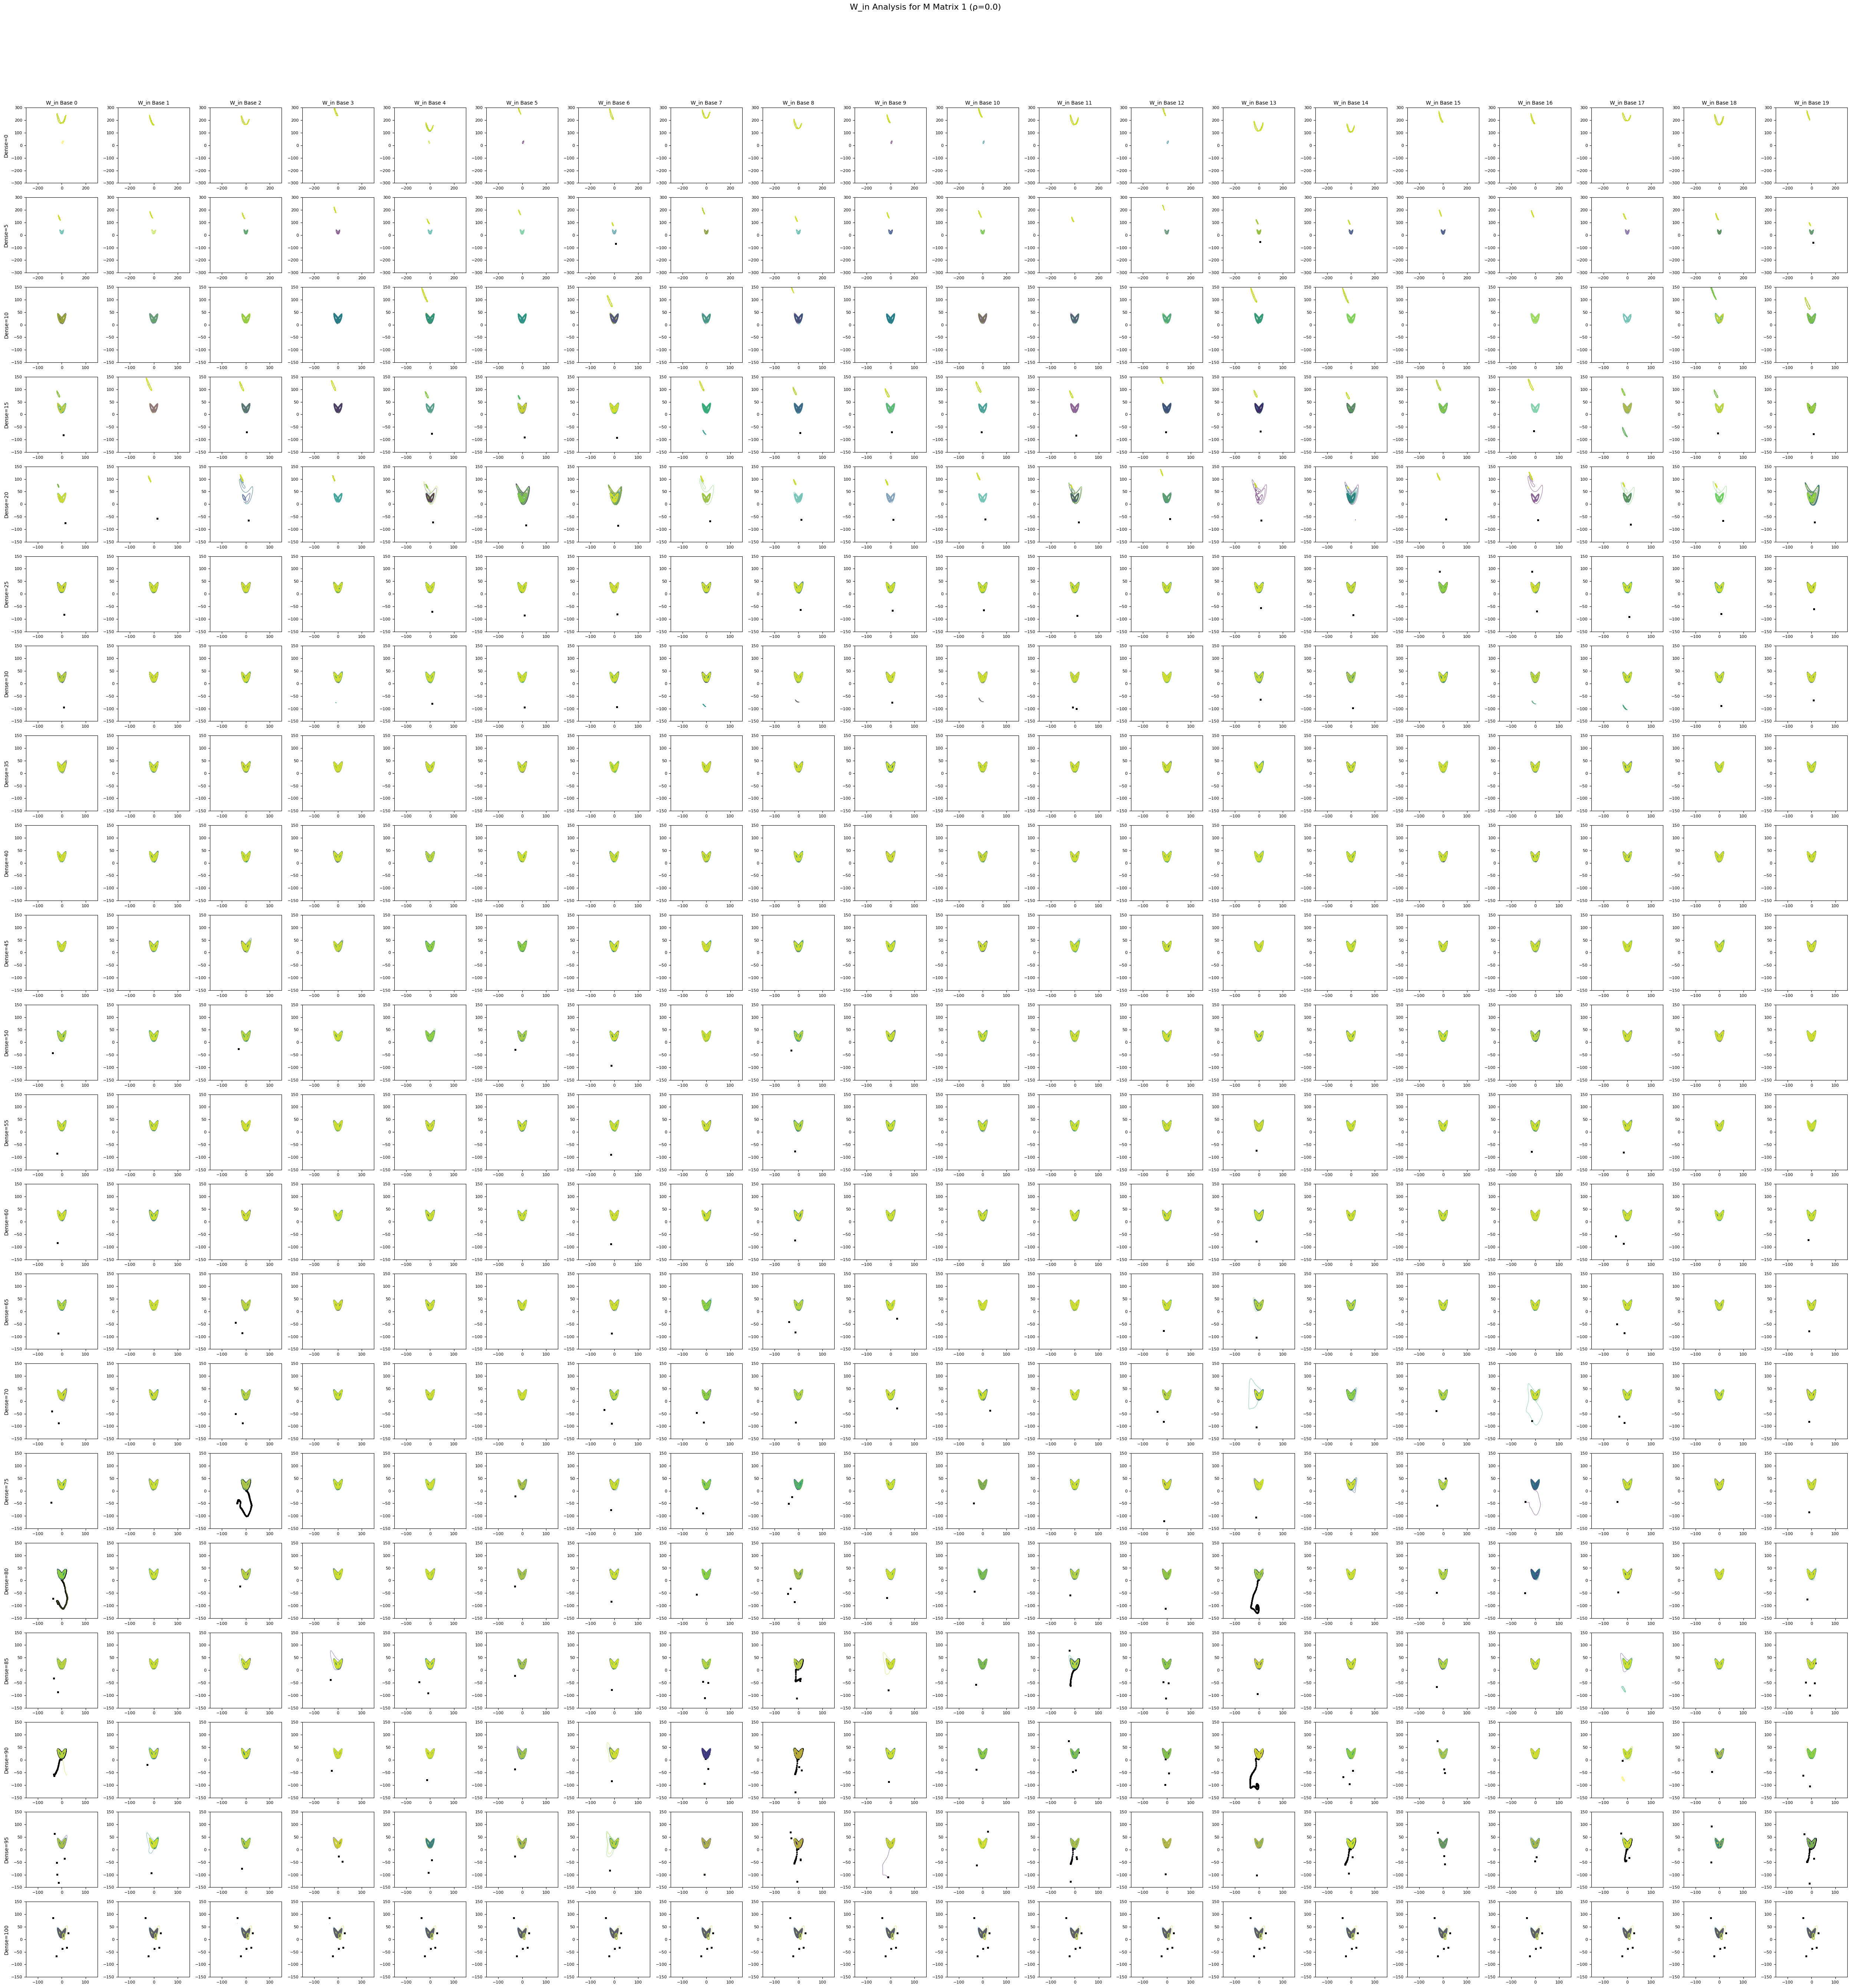


--- Plotting Complete ---


In [6]:
# ============================================================================
# CONTROL PANEL & EXECUTION FOR PLOTTING
# ============================================================================

# --- 1. DEFINE PLOTTING PARAMETERS ---
# These should match the parameters from your simulation run
TARGET_MATRICES_TO_PLOT = [1] 
SPECTRAL_RADII_TO_PLOT = [0.0]
NUM_W_IN_TO_PLOT = 20
DENSITY_LEVELS_TO_PLOT = [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]

# --- 2. DEFINE PLOT APPEARANCE ---
DEFAULT_X_LIMITS = [-150, 150]
DEFAULT_Y_LIMITS = [-150, 150]
SPECIAL_LIMITS = {
    0: ([-300, 300], [-300, 300]),
    5: ([-300, 300], [-300, 300])
}
PLOT_DURATION_SECONDS = 40.0

# --- 3. GENERATE AND SAVE PLOTS ---
print("\n--- Generating visualization grids for specified spectral radii ---")

for rho_to_plot in SPECTRAL_RADII_TO_PLOT:
    print(f"\n--- Plotting results for ρ = {rho_to_plot} ---")
    for matrix_to_plot in TARGET_MATRICES_TO_PLOT:
        print(f"  Plotting grid for M matrix {matrix_to_plot}...")
        
        plot_customizable_grid(
            matrix_idx=matrix_to_plot,
            rho_val=rho_to_plot,
            rows_to_plot=DENSITY_LEVELS_TO_PLOT,
            cols_to_plot=list(range(NUM_W_IN_TO_PLOT)),
            default_xlim=DEFAULT_X_LIMITS,
            default_ylim=DEFAULT_Y_LIMITS,
            special_limits=SPECIAL_LIMITS,
            plot_last_seconds=PLOT_DURATION_SECONDS
        )
        
        plt.savefig(f'w_in_robustness_matrix_{matrix_to_plot}_rho{rho_to_plot}.png',
                    dpi=200, bbox_inches='tight')
        plt.show()
        plt.close()

print("\n--- Plotting Complete ---")


--- Generating visualization grids for specified spectral radii ---

--- Plotting results for ρ = 0.01 ---
  Plotting grid for M matrix 1...


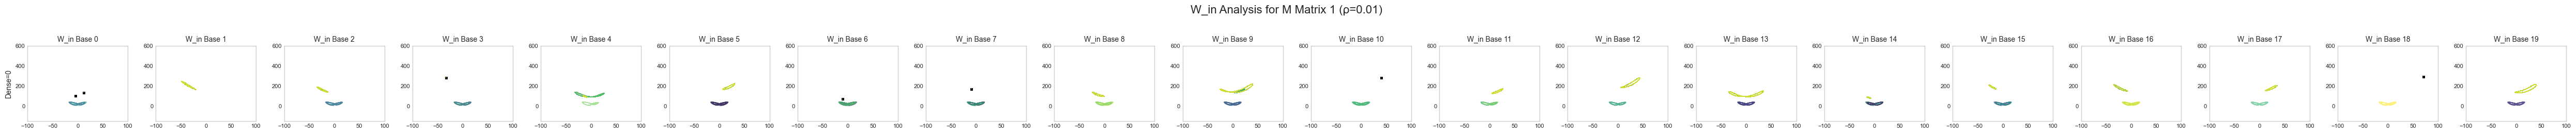


--- Plotting Complete ---


In [44]:
# ============================================================================
# CONTROL PANEL & EXECUTION FOR PLOTTING
# ============================================================================

# --- 1. DEFINE PLOTTING PARAMETERS ---
# These should match the parameters from your simulation run
TARGET_MATRICES_TO_PLOT = [1] 
SPECTRAL_RADII_TO_PLOT = [0.01]
NUM_W_IN_TO_PLOT = 20
DENSITY_LEVELS_TO_PLOT = [0]

# --- 2. DEFINE PLOT APPEARANCE ---
DEFAULT_X_LIMITS = [-300, 300]
DEFAULT_Y_LIMITS = [-300, 300]
SPECIAL_LIMITS = {
    0: ([-100, 100], [-150, 600]),
    5: ([-150, 150], [-150, 150])
}
PLOT_DURATION_SECONDS = 15.0

# --- 3. GENERATE AND SAVE PLOTS ---
print("\n--- Generating visualization grids for specified spectral radii ---")

for rho_to_plot in SPECTRAL_RADII_TO_PLOT:
    print(f"\n--- Plotting results for ρ = {rho_to_plot} ---")
    for matrix_to_plot in TARGET_MATRICES_TO_PLOT:
        print(f"  Plotting grid for M matrix {matrix_to_plot}...")
        
        plot_customizable_grid(
            matrix_idx=matrix_to_plot,
            rho_val=rho_to_plot,
            rows_to_plot=DENSITY_LEVELS_TO_PLOT,
            cols_to_plot=list(range(NUM_W_IN_TO_PLOT)),
            default_xlim=DEFAULT_X_LIMITS,
            default_ylim=DEFAULT_Y_LIMITS,
            special_limits=SPECIAL_LIMITS,
            plot_last_seconds=PLOT_DURATION_SECONDS
        )
        
        plt.savefig(f'w_in_robustness_matrix_{matrix_to_plot}_rho{rho_to_plot}.png',
                    dpi=200, bbox_inches='tight')
        plt.show()
        plt.close()

print("\n--- Plotting Complete ---")

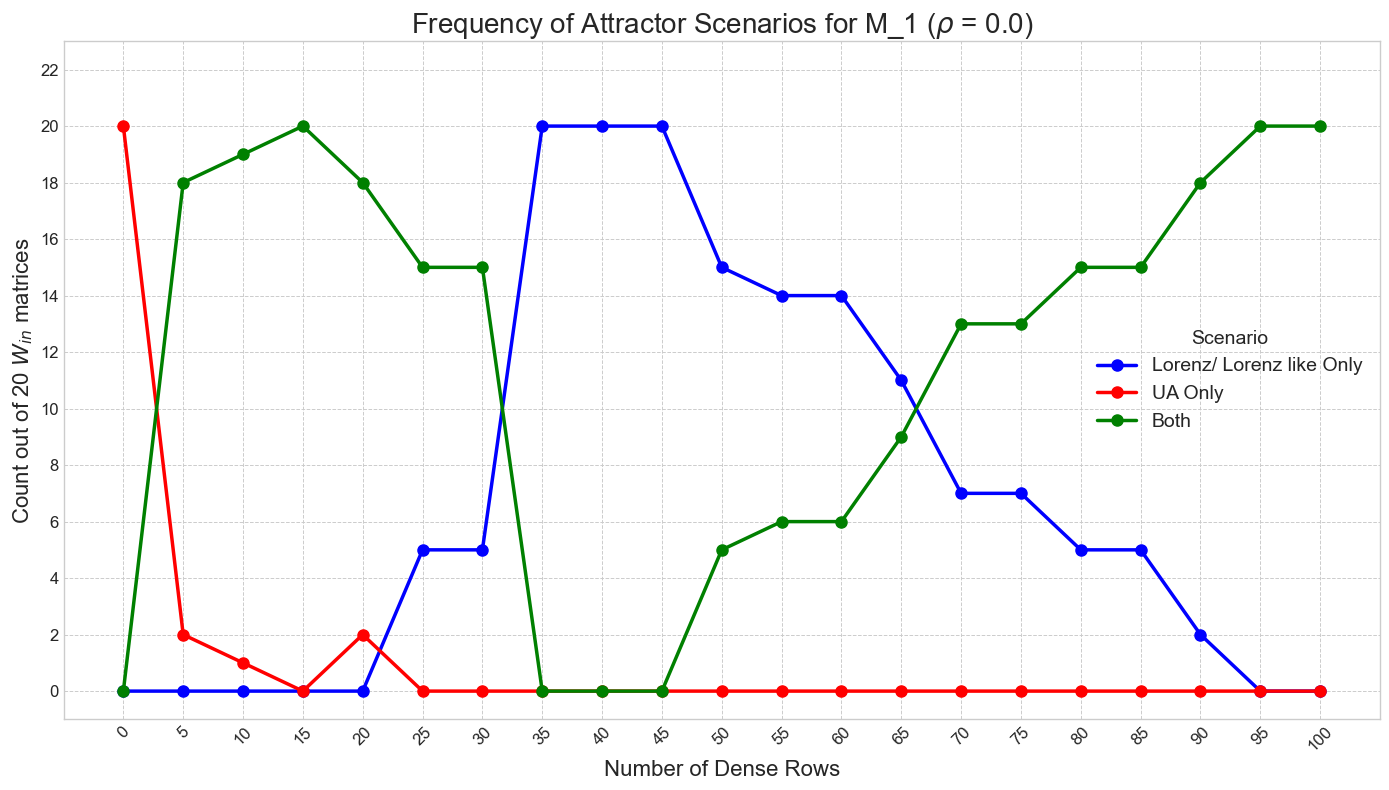

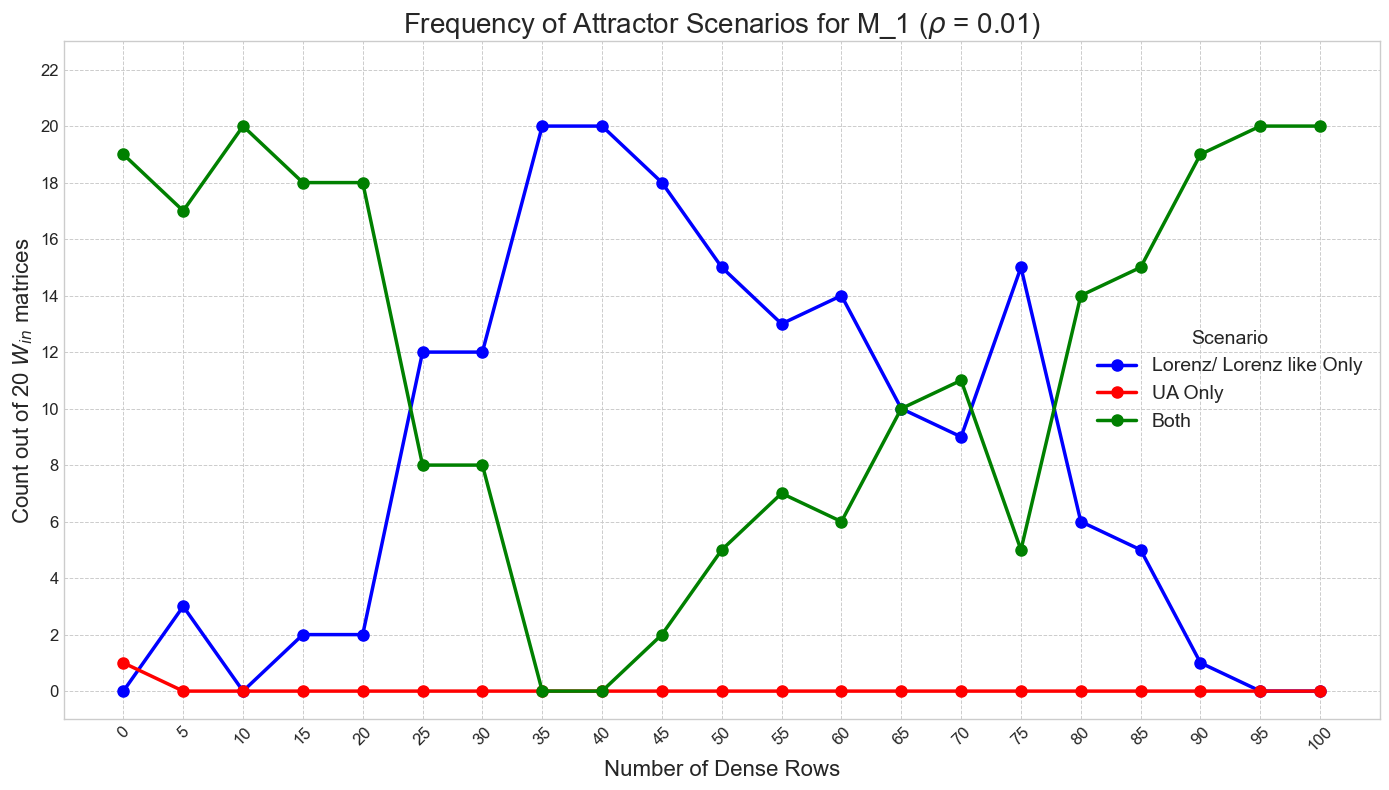

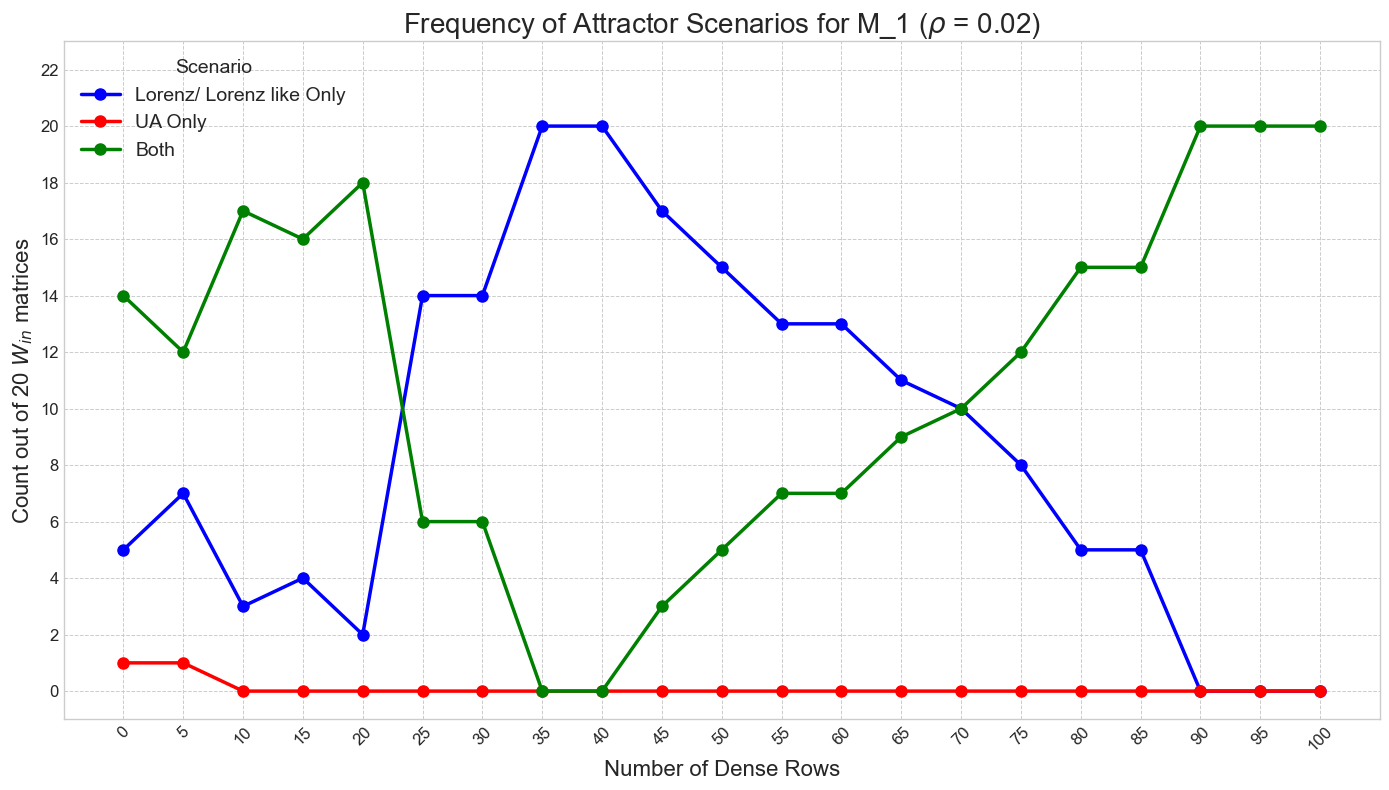

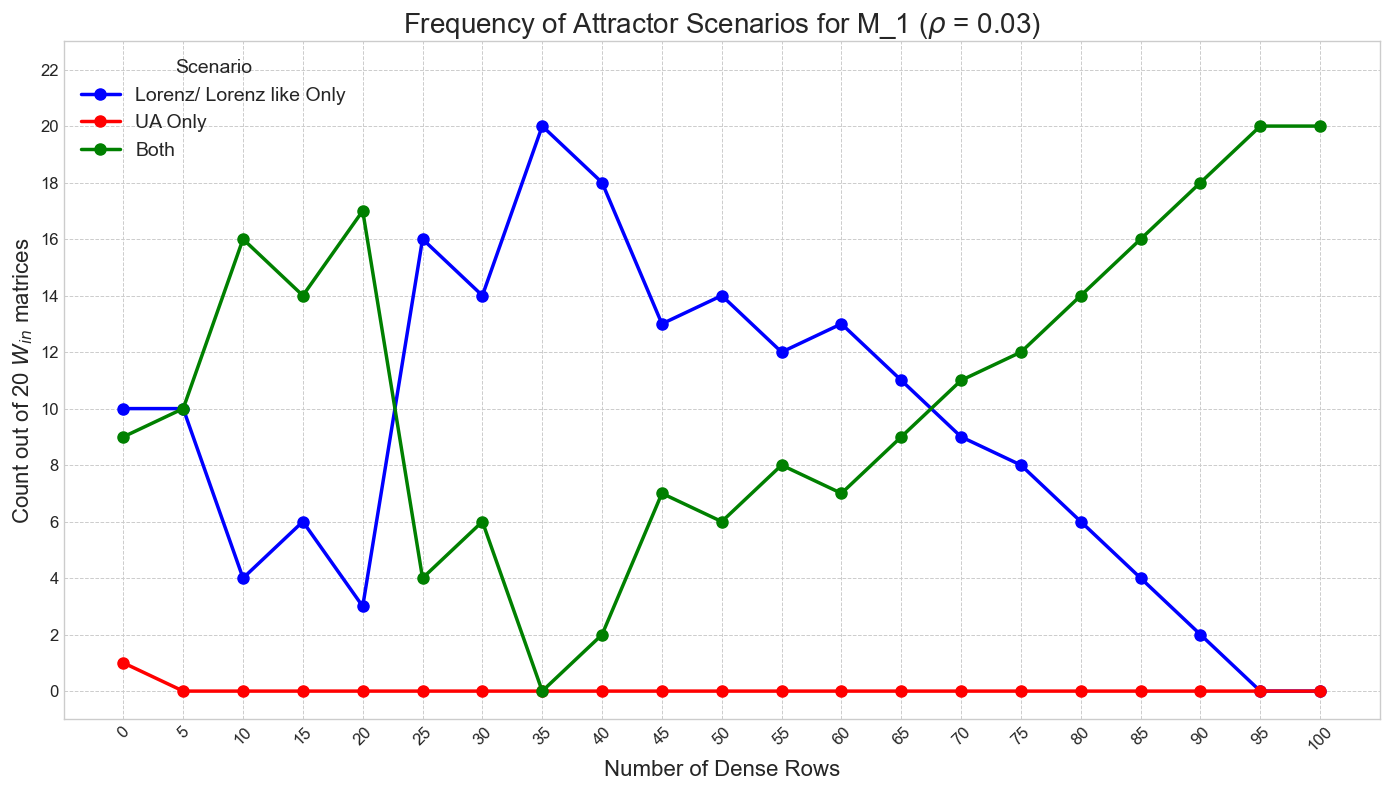

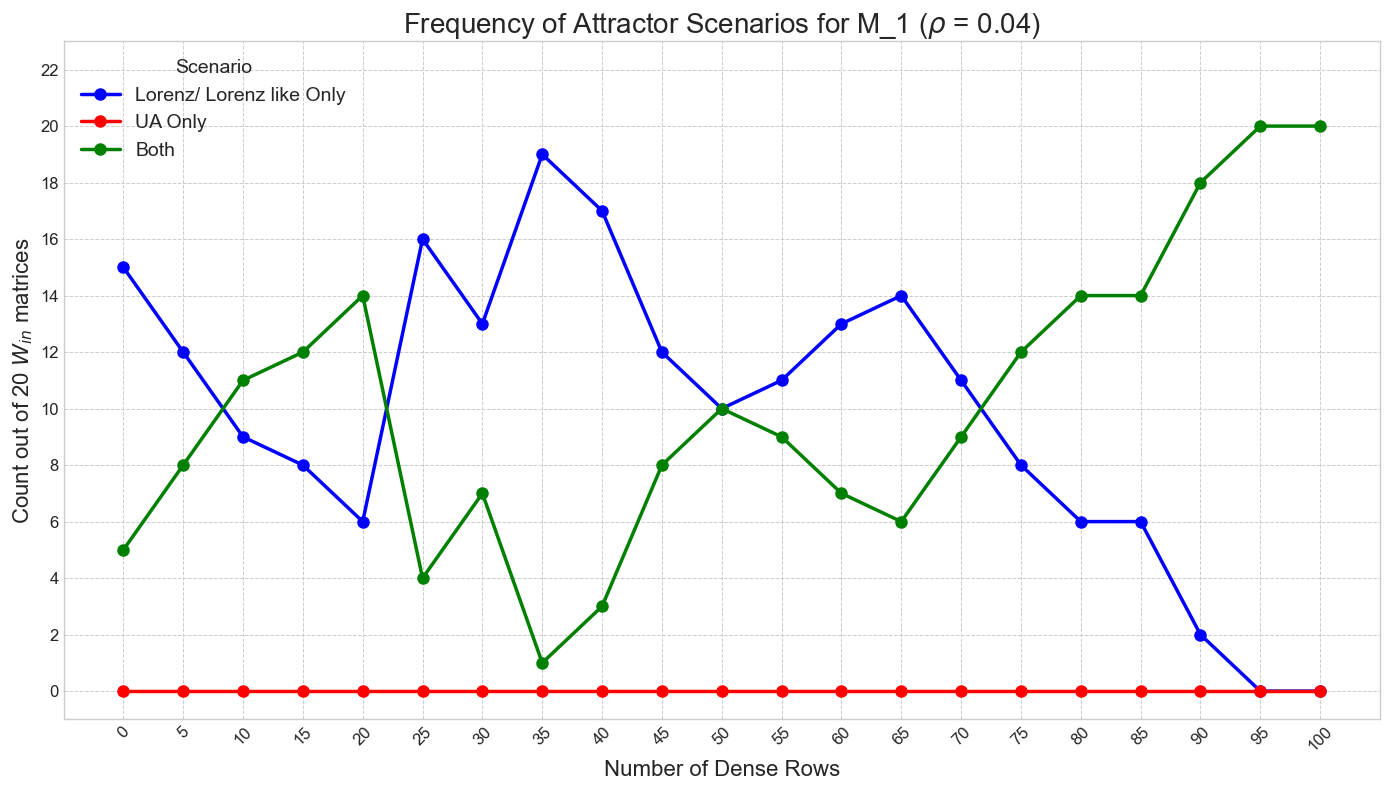

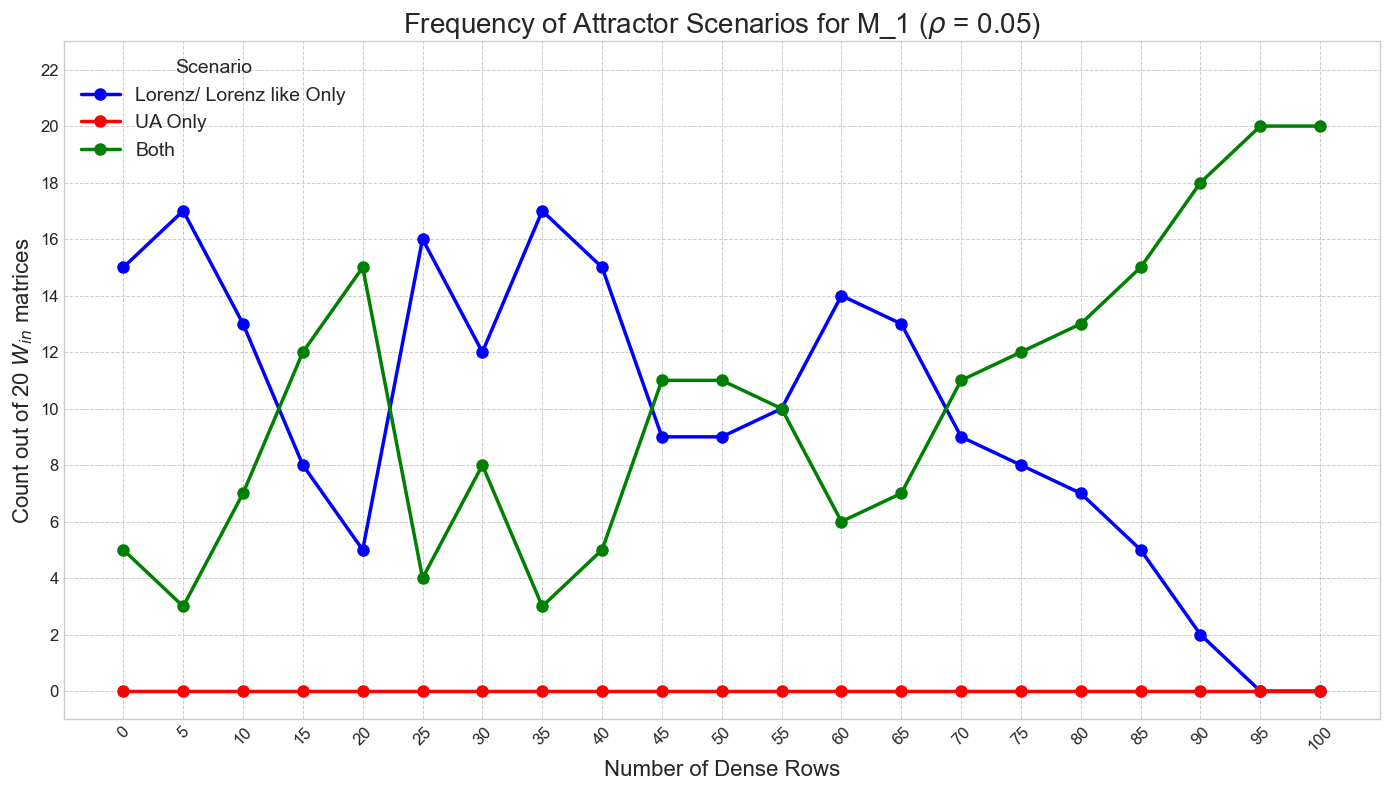

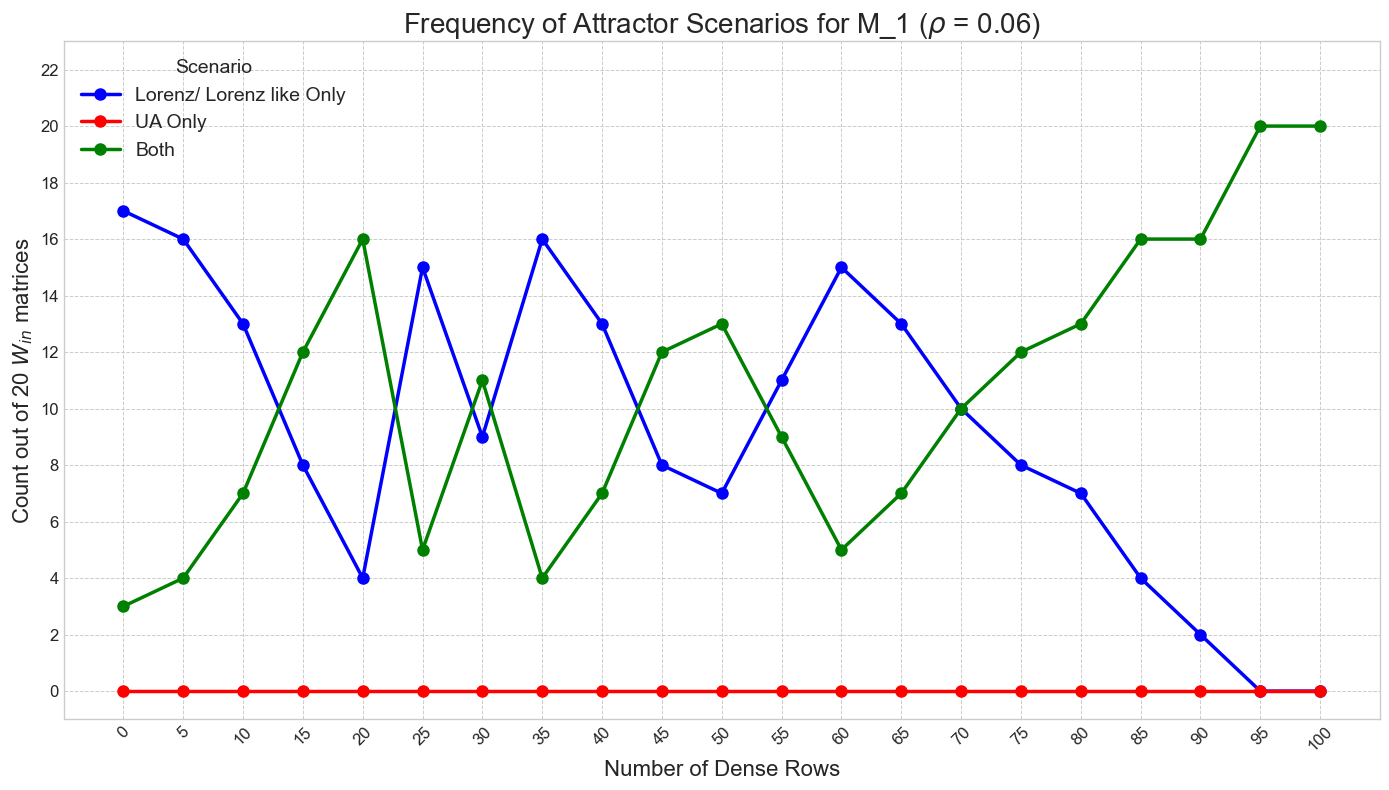

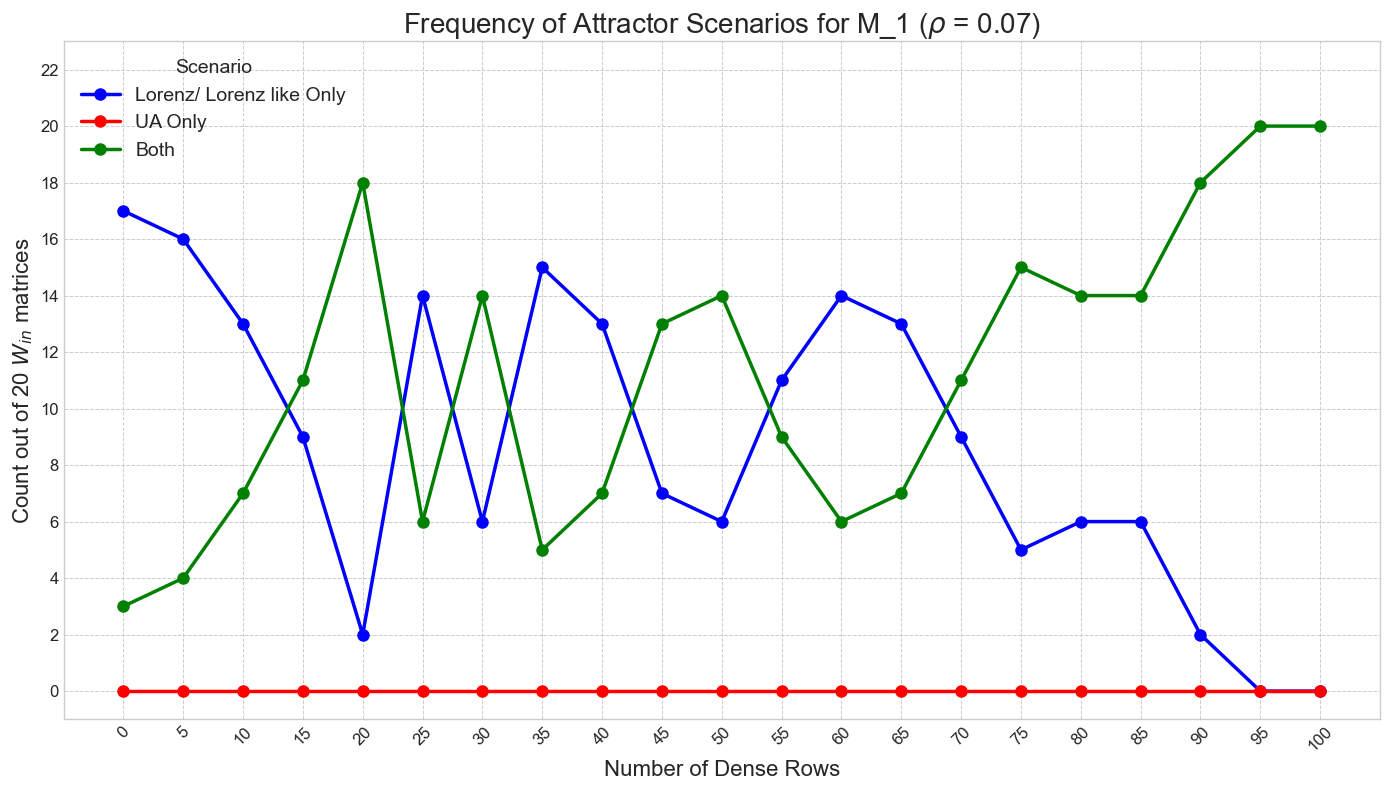

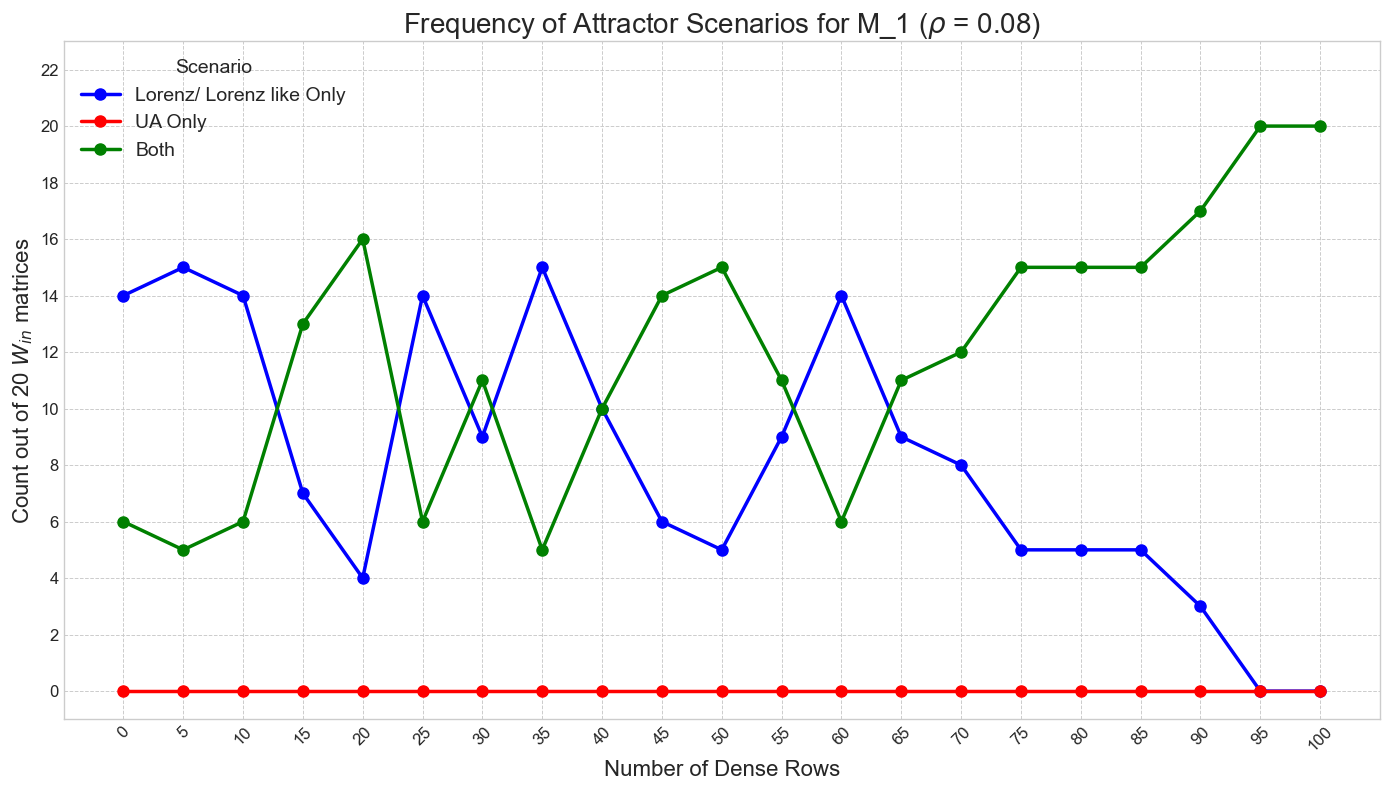

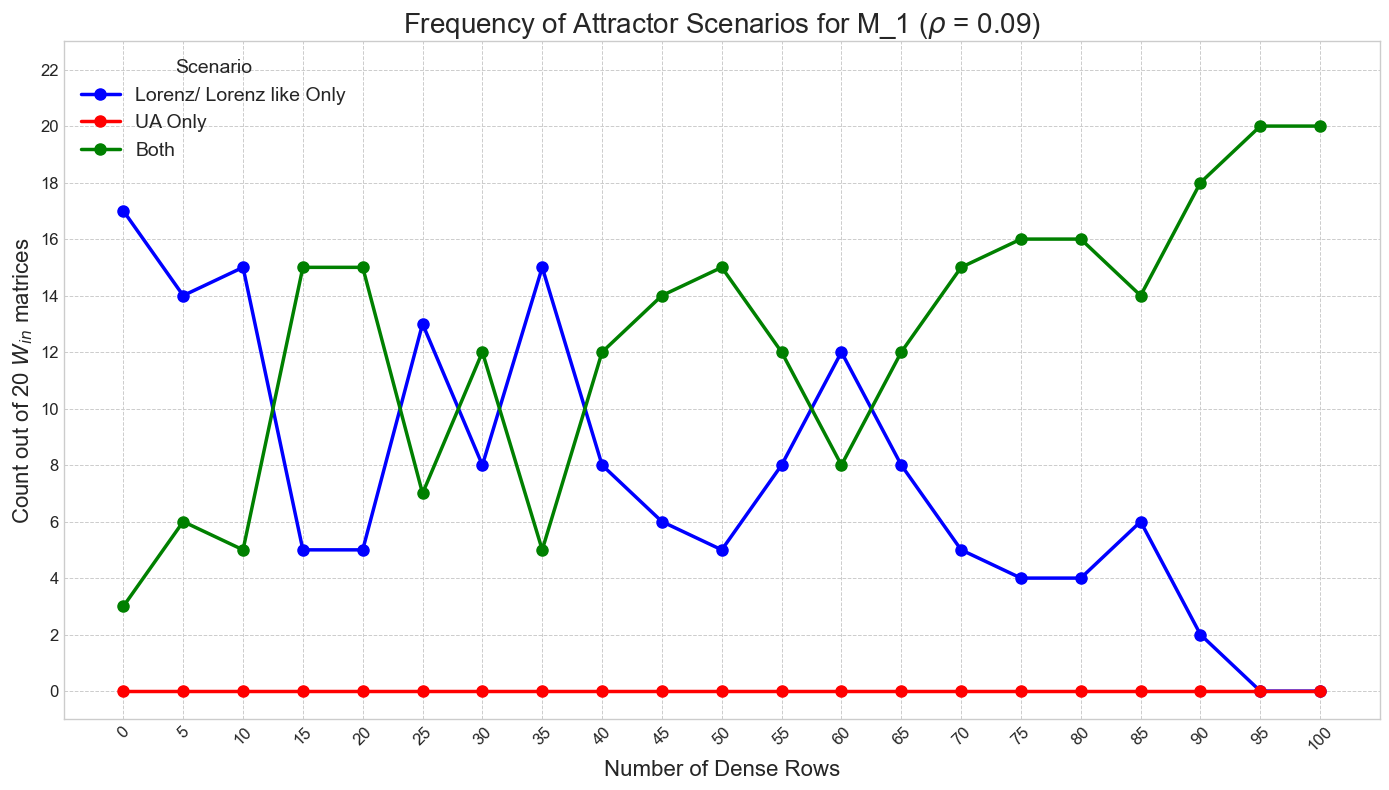

In [9]:
from matplotlib.ticker import MaxNLocator

# ============================================================================
# PLOTTING FUNCTION
# ============================================================================

def plot_frequency_curves(rho_val, data, density_levels, y_axis_mode='count'):
    """
    Generates a high-quality frequency curve plot suitable for publication.
    """
    df = pd.DataFrame(data, index=density_levels)
    
    # --- Convert to Percentage if requested ---
    if y_axis_mode == 'percentage':
        df = (df / 20.0) * 100
        y_label = 'Frequency (% of $W_{in}$ matrices)'
    else:
        y_label = 'Count out of 20 $W_{in}$ matrices'

    # --- Create the Plot ---
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(14, 8)) 

    # --- Define colors and plot each curve ---
    colors = {
        'Lorenz/ Lorenz like Only': 'blue',
        'UA Only': 'red',
        'Both': 'green'
    }
    
    for scenario, color in colors.items():
        if scenario in df.columns:
            ax.plot(df.index, df[scenario], marker='o', linestyle='-', label=scenario, color=color, markersize=8, linewidth=2.5)

    # --- Formatting for Publication ---
    ax.set_title(f'Frequency of Attractor Scenarios for M_1 ($\\rho$ = {rho_val})', fontsize=20)
    ax.set_xlabel('Number of Dense Rows', fontsize=16)
    ax.set_ylabel(y_label, fontsize=16)
    ax.set_xticks(density_levels)
    ax.tick_params(axis='x', rotation=45, labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.legend(title='Scenario', fontsize=14, title_fontsize=14)
    ax.grid(True, which='both', linestyle='--', linewidth=0.7)
    
    # --- Set Y-axis limits and ensure integer ticks for 'count' mode ---
    if y_axis_mode == 'percentage':
        ax.set_ylim(-5, 105)
    else:
        ax.set_ylim(-1, 23) # Adjusted limit to show 22
        ax.set_yticks(np.arange(0, 23, 2)) # THIS SETS THE TICKS TO 0, 2, 4,... 22
        
    plt.tight_layout()
    plt.show()


# ============================================================================
# DATA & CONTROL PANEL
# ============================================================================

# --- 1. ENTER YOUR MANUAL COUNTS HERE ---
manual_counts = {
    0.0: {
        'Lorenz/ Lorenz like Only' : [0, 0, 0, 0, 0, 5, 5,20, 20, 20, 15, 14, 14, 11, 7, 7, 5, 5, 2, 0, 0],
        'UA Only':     [20, 2, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,0, 0],
        'Both':        [0, 18, 19,20, 18, 15, 15, 0, 0, 0, 5, 6, 6, 9, 13, 13, 15, 15, 18, 20, 20]
    },
    0.01: {
        'Lorenz/ Lorenz like Only': [0, 3, 0, 2, 2, 12, 12, 20, 20, 18, 15, 13, 14, 10, 9, 15, 6, 5,1,0,0],
        'UA Only':     [1,0,0, 0,0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        'Both':        [19, 17,20,18,18,8,8,0,0,2,5,7,6,10,11,5,14,15,19,20,20]
    },
    0.02: {
        'Lorenz/ Lorenz like Only': [5, 7, 3, 4,2, 14, 14, 20, 20, 17, 15, 13, 13, 11, 10, 8, 5,5,0, 0, 0],
        'UA Only':     [1,1,0,0,0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        'Both':        [14,12, 17,16, 18, 6, 6, 0, 0, 3, 5, 7, 7,9,10,12, 15, 15, 20,20,20]
    },
    0.03: {
        'Lorenz/ Lorenz like Only': [10, 10, 4, 6, 3, 16, 14, 20, 18, 13, 14, 12, 13, 11, 9, 8, 6, 4, 2, 0, 0],
        'UA Only':     [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        'Both':        [9, 10, 16, 14, 17, 4, 6, 0, 2, 7, 6, 8, 7, 9, 11, 12, 14, 16, 18, 20, 20]
    },
    0.04: {
        'Lorenz/ Lorenz like Only': [15, 12, 9, 8, 6,16,13, 19, 17, 12, 10, 11, 13, 14, 11, 8, 6, 6, 2, 0, 0],
        'UA Only':     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        'Both':        [5, 8, 11 ,12,14, 4, 7, 1,3,8, 10, 9, 7, 6, 9, 12, 14, 14, 18, 20, 20]
    },
    0.05: {
        'Lorenz/ Lorenz like Only': [15, 17, 13 , 8, 5, 16, 12, 17, 15, 9, 9, 10, 14, 13, 9, 8, 7, 5, 2, 0, 0],
        'UA Only':     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        'Both':        [5, 3, 7, 12, 15, 4, 8, 3, 5, 11, 11, 10, 6, 7, 11, 12, 13, 15, 18, 20, 20]
    },
    0.06: {
        'Lorenz/ Lorenz like Only': [17, 16, 13, 8, 4, 15, 9, 16, 13, 8 , 7,  11, 15, 13, 10, 8, 7, 4, 2,0,0 ],
        'UA Only':     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        'Both':        [3, 4, 7,  12, 16 , 5, 11, 4, 7, 12, 13, 9, 5, 7, 10, 12, 13, 16, 16, 20, 20]
    },
    0.07: {
        'Lorenz/ Lorenz like Only': [17, 16,13, 9, 2, 14, 6, 15, 13, 7, 6, 11, 14, 13, 9, 5, 6, 6, 2, 0, 0],
        'UA Only':     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        'Both':        [3, 4, 7 , 11,  18, 6, 14, 5, 7, 13, 14, 9, 6,7 , 11, 15, 14,14, 18, 20,20 ]
    },
    0.08: {
        'Lorenz/ Lorenz like Only': [14,15,14,7,4,14,9,15,10,6,5,9,14,9,8,5,5,5,3,0,0],
        'UA Only':     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        'Both':        [6, 5, 6, 13,16, 6,11,5,10,14,15,11,6,11,12,15,15,15,17,20,20,]
    },
    0.09: {
        'Lorenz/ Lorenz like Only': [17,14,15,5,5,13,8,15,8,6,5,8,12,8,5,4,4,6,2,0,0],
        'UA Only':     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        'Both':        [3,6,5,15,15,7,12,5,12,14,15,12,8,12,15,16,16,14,18,20,20]
    }
}

# --- 2. CHOOSE YOUR Y-AXIS TYPE ---
# Options: 'count' or 'percentage'
Y_AXIS_MODE = 'count'

# --- 3. EXECUTION ---
# This loop will generate a separate plot for each rho value in the data.
DENSITY_LEVELS = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]

for rho, data in manual_counts.items():
    plot_frequency_curves(rho, data, DENSITY_LEVELS, Y_AXIS_MODE)


In [11]:
manual_counts = {
    0.0: {
        'Lorenz/ Lorenz like Only' : [0, 0, 0, 0, 0, 5, 5,20, 20, 20, 15, 14, 14, 11, 7, 7, 5, 5, 2, 0, 0],
        'UA Only':     [20, 2, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,0, 0],
        'Both':        [0, 18, 19,20, 18, 15, 15, 0, 0, 0, 5, 6, 6, 9, 13, 13, 15, 15, 18, 20, 20]
    },
    0.01: {
        'Lorenz/ Lorenz like Only': [0, 3, 0, 2, 2, 12, 12, 20, 20, 18, 15, 13, 14, 10, 9, 15, 6, 5,1,0,0],
        'UA Only':     [1,0,0, 0,0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        'Both':        [19, 17,20,18,18,8,8,0,0,2,5,7,6,10,11,5,14,15,19,20,20]
    },
    0.02: {
        'Lorenz/ Lorenz like Only': [5, 7, 3, 4,2, 14, 14, 20, 20, 17, 15, 13, 13, 11, 10, 8, 5,5,0, 0, 0],
        'UA Only':     [1,1,0,0,0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        'Both':        [14,12, 17,16, 18, 6, 6, 0, 0, 3, 5, 7, 7,9,10,12, 15, 15, 20,20,20]
    },
    0.03: {
        'Lorenz/ Lorenz like Only': [10, 10, 4, 6, 3, 16, 14, 20, 18, 13, 14, 12, 13, 11, 9, 8, 6, 4, 2, 0, 0],
        'UA Only':     [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        'Both':        [9, 10, 16, 14, 17, 4, 6, 0, 2, 7, 6, 8, 7, 9, 11, 12, 14, 16, 18, 20, 20]
    },
    0.04: {
        'Lorenz/ Lorenz like Only': [15, 12, 9, 8, 6,16,13, 19, 17, 12, 10, 11, 13, 14, 11, 8, 6, 6, 2, 0, 0],
        'UA Only':     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        'Both':        [5, 8, 11 ,12,14, 4, 7, 1,3,8, 10, 9, 7, 6, 9, 12, 14, 14, 18, 20, 20]
    },
    0.05: {
        'Lorenz/ Lorenz like Only': [15, 17, 13 , 8, 5, 16, 12, 17, 15, 9, 9, 10, 14, 13, 9, 8, 7, 5, 2, 0, 0],
        'UA Only':     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        'Both':        [5, 3, 7, 12, 15, 4, 8, 3, 5, 11, 11, 10, 6, 7, 11, 12, 13, 15, 18, 20, 20]
    },
    0.06: {
        'Lorenz/ Lorenz like Only': [17, 16, 13, 8, 4, 15, 9, 16, 13, 8 , 7,  11, 15, 13, 10, 8, 7, 4, 2,0,0 ],
        'UA Only':     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        'Both':        [3, 4, 7,  12, 16 , 5, 11, 4, 7, 12, 13, 9, 5, 7, 10, 12, 13, 16, 16, 20, 20]
    },
    0.07: {
        'Lorenz/ Lorenz like Only': [17, 16,13, 9, 2, 14, 6, 15, 13, 7, 6, 11, 14, 13, 9, 5, 6, 6, 2, 0, 0],
        'UA Only':     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        'Both':        [3, 4, 7 , 11,  18, 6, 14, 5, 7, 13, 14, 9, 6,7 , 11, 15, 14,14, 18, 20,20 ]
    },
    0.08: {
        'Lorenz/ Lorenz like Only': [14,15,14,7,4,14,9,15,10,6,5,9,14,9,8,5,5,5,3,0,0],
        'UA Only':     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        'Both':        [6, 5, 6, 13,16, 6,11,5,10,14,15,11,6,11,12,15,15,15,17,20,20,]
    },
    0.09: {
        'Lorenz/ Lorenz like Only': [17,14,15,5,5,13,8,15,8,6,5,8,12,8,5,4,4,6,2,0,0],
        'UA Only':     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        'Both':        [3,6,5,15,15,7,12,5,12,14,15,12,8,12,15,16,16,14,18,20,20]
    }
}


In [14]:
manual_counts[0.0 ]['UA Only'] 

[20, 2, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [15]:
key_list = np.linspace(0.0, 0.09, 10 )  

In [16]:
key_list


array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09])

In [17]:
ua_only_heatmap = []

for i in key_list : 
    ua_only_heatmap.append(manual_counts[i]['UA Only'])

ua_only_heatmap = np.array(ua_only_heatmap) 


In [18]:
ua_only_heatmap

array([[20,  2,  1,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0],
       [ 1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,

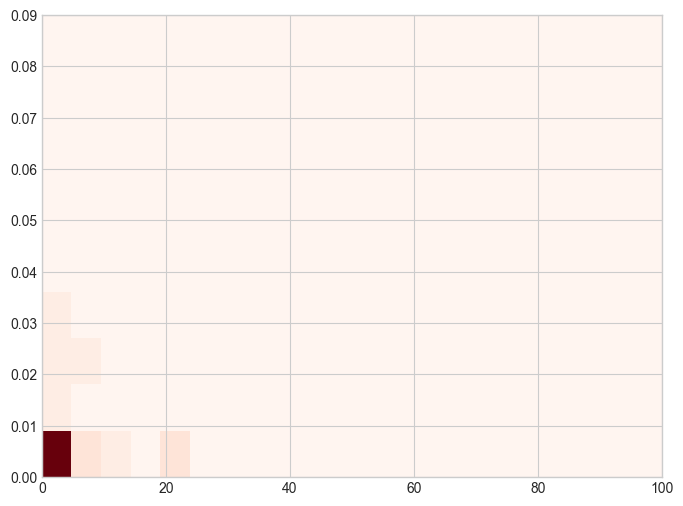

In [39]:
plt.figure(figsize = (8,6))
plt.imshow(ua_only_heatmap,extent = [0, 100, 0.0, 0.09],vmin = 0, vmax = 20, cmap = 'Reds', origin = 'lower', aspect = 'auto')

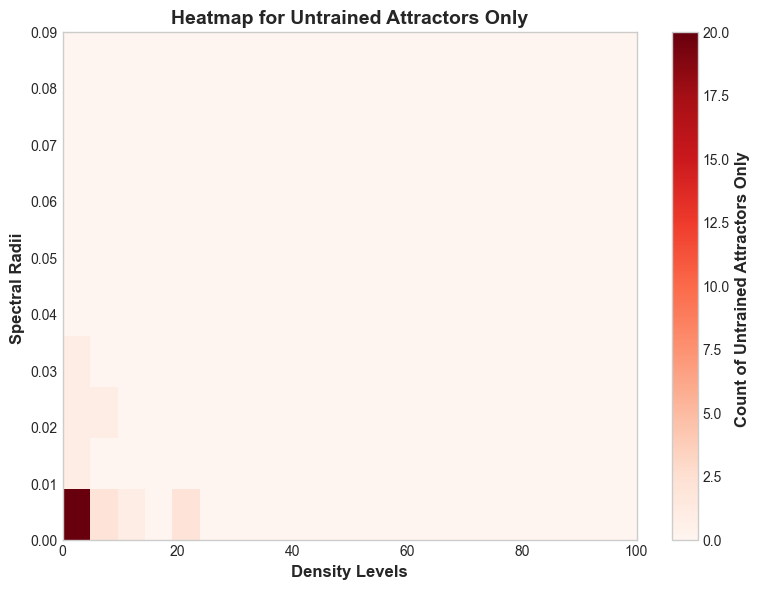

In [23]:
import numpy as np


ua_only_heatmap = np.array(ua_only_heatmap) 

fig, ax = plt.subplots(figsize=(8, 6))

#  figure's background color to white to remove the grid-like effect
fig.patch.set_facecolor('white')

ax.grid(False)

# --- Plot the heatmap on the axes object ---
im = ax.imshow(
    ua_only_heatmap,
    extent=[0, 100, 0.0, 0.09],
    vmin=0,
    vmax=20,
    cmap='Reds',
    origin='lower',
    aspect='auto'
)


# Add a colorbar with a descriptive label
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Count of Untrained Attractors Only ', fontsize=12, weight='bold')

# Add labels for the x and y axes
ax.set_xlabel('Density Levels', fontsize=12, weight='bold')
ax.set_ylabel('Spectral Radii ', fontsize=12, weight='bold')

# Add a clear title
ax.set_title('Heatmap for Untrained Attractors Only', fontsize=14, weight='bold')

# 4. Ensure a clean layout
plt.tight_layout()

plt.show()

In [16]:
l_only_heatmap = []

for i in key_list : 
    l_only_heatmap.append(manual_counts[i]['Lorenz/ Lorenz like Only'])

l_only_heatmap = np.array(l_only_heatmap) 


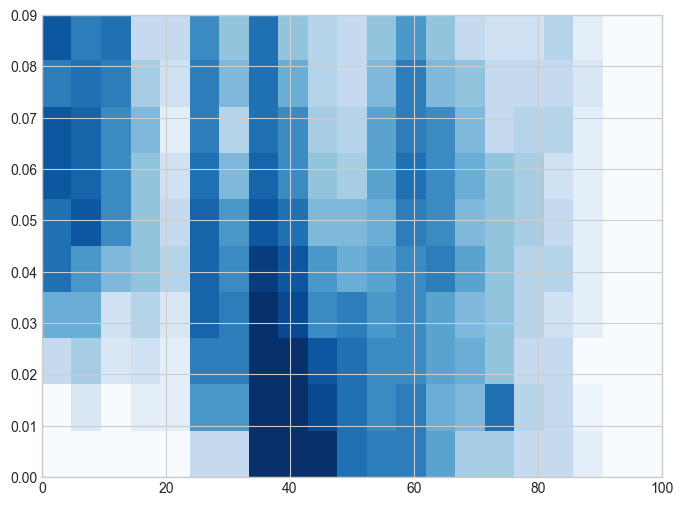

In [41]:
plt.figure(figsize = (8,6))
plt.imshow(l_only_heatmap,extent = [0, 100, 0.0, 0.09],vmin = 0, vmax = 20, cmap = 'Blues', origin = 'lower', aspect = 'auto')

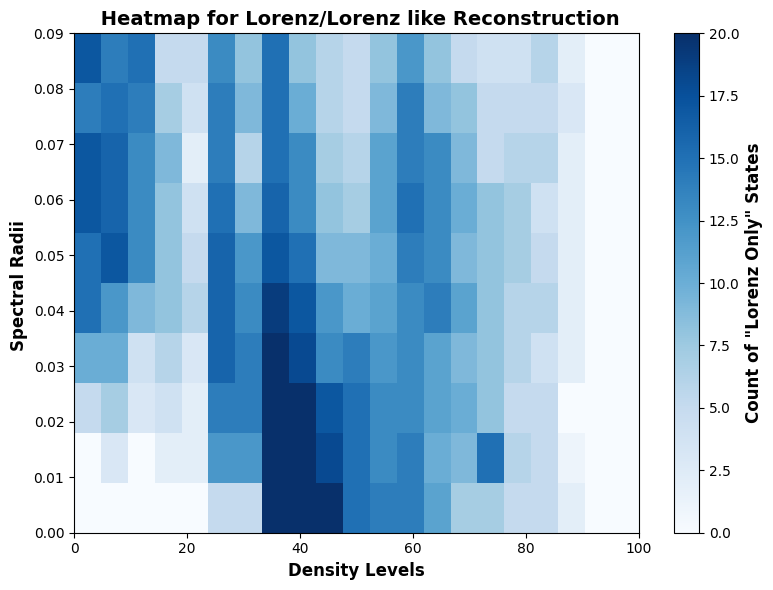

In [23]:
import numpy as np


l_only_heatmap = np.array(l_only_heatmap) 

fig, ax = plt.subplots(figsize=(8, 6))

#  figure's background color to white to remove the grid-like effect
fig.patch.set_facecolor('white')

# --- Plot the heatmap on the axes object ---
im = ax.imshow(
    l_only_heatmap,
    extent=[0, 100, 0.0, 0.09],
    vmin=0,
    vmax=20,
    cmap='Blues',
    origin='lower',
    aspect='auto'
)


# Add a colorbar with a descriptive label
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Count of "Lorenz Only" States', fontsize=12, weight='bold')

# Add labels for the x and y axes
ax.set_xlabel('Density Levels', fontsize=12, weight='bold')
ax.set_ylabel('Spectral Radii ', fontsize=12, weight='bold')

# Add a clear title
ax.set_title(' Heatmap for Lorenz/Lorenz like Reconstruction', fontsize=14, weight='bold')

# 4. Ensure a clean layout
plt.tight_layout()

plt.show()

In [25]:
b_only_heatmap = []

for i in key_list : 
    b_only_heatmap.append(manual_counts[i]['Both'])

b_only_heatmap = np.array(b_only_heatmap) 


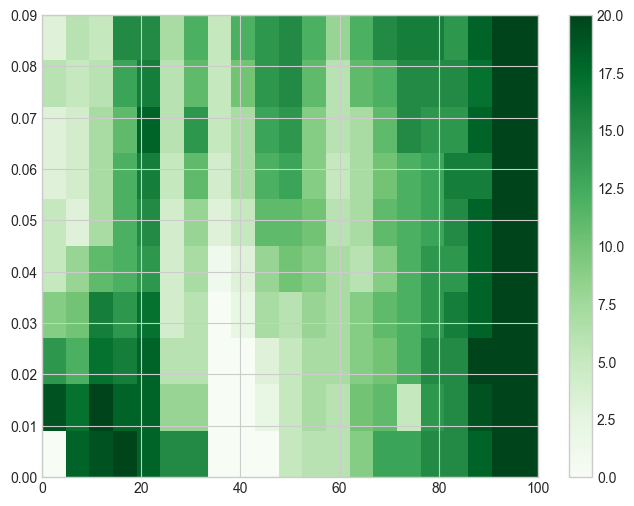

In [28]:
plt.figure(figsize = (8,6))
fig.patch.set_facecolor('white')
ax.grid(False)
plt.imshow(b_only_heatmap,extent = [0, 100, 0.0, 0.09],vmin = 0, vmax = 20, cmap = 'Greens', origin = 'lower', aspect = 'auto')
plt.colorbar()

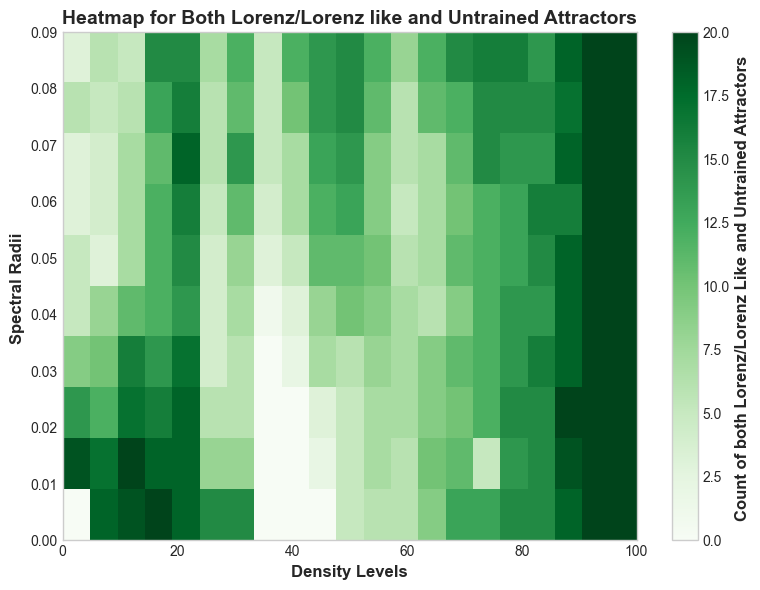

In [31]:
import numpy as np


b_only_heatmap = np.array(b_only_heatmap) 

fig, ax = plt.subplots(figsize=(8, 6))

#  figure's background color to white to remove the grid-like effect
fig.patch.set_facecolor('white')
ax.grid(False)

# --- Plot the heatmap on the axes object ---
im = ax.imshow(
    b_only_heatmap,
    extent=[0, 100, 0.0, 0.09],
    vmin=0,
    vmax=20,
    cmap='Greens',
    origin='lower',
    aspect='auto'
)


# Add a colorbar with a descriptive label
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Count of both Lorenz/Lorenz Like and Untrained Attractors ', fontsize=12, weight='bold')

# Add labels for the x and y axes
ax.set_xlabel('Density Levels', fontsize=12, weight='bold')
ax.set_ylabel('Spectral Radii ', fontsize=12, weight='bold')

# Add a clear title
ax.set_title('Heatmap for Both Lorenz/Lorenz like and Untrained Attractors', fontsize=14, weight='bold')

# 4. Ensure a clean layout
plt.tight_layout()

plt.show()

Generating single subplot for M=1, Dense=0, W_in=0...


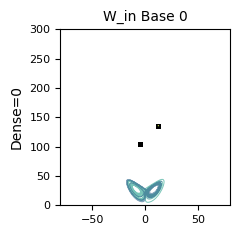

In [34]:
# ============================================================================
#FOR A SINGLE SUBPLOT
# ============================================================================

# --- 1. CHOOSE WHICH MATRIX TO PLOT ---
TARGET_M_MATRIX = 1 # Set the specific M matrix index

# --- 2. DEFINE WHICH SINGLE ROW AND COLUMN TO PLOT ---
DENSITY_ROWS_TO_PLOT = [0] # <-- List contains only the desired row
W_IN_COLS_TO_PLOT    = [0]  # <-- List contains only the desired column

# --- 3. SET PLOT LIMITS  ---
DEFAULT_X_LIMITS = [-80, 80]
DEFAULT_Y_LIMITS = [-120, 120]
SPECIAL_LIMITS = {
    0: ([-80, 80], [ 0, 300]),
    1: ([-50, 50], [-50, 150])
}

# --- 4. SET THE DURATION TO PLOT ---
PLOT_DURATION_SECONDS = 15.0

# --- 5. RUN THE PLOTTING FUNCTION ---
print(f"Generating single subplot for M={TARGET_M_MATRIX}, Dense={DENSITY_ROWS_TO_PLOT[0]}, W_in={W_IN_COLS_TO_PLOT[0]}...")
plot_customizable_grid(
    matrix_idx=TARGET_M_MATRIX,
    rows_to_plot=DENSITY_ROWS_TO_PLOT,
    cols_to_plot=W_IN_COLS_TO_PLOT,
    default_xlim=DEFAULT_X_LIMITS,
    default_ylim=DEFAULT_Y_LIMITS,
    special_limits=SPECIAL_LIMITS,
    plot_last_seconds=PLOT_DURATION_SECONDS,
    rho_val = 0.01
)
plt.show() # Display the plot